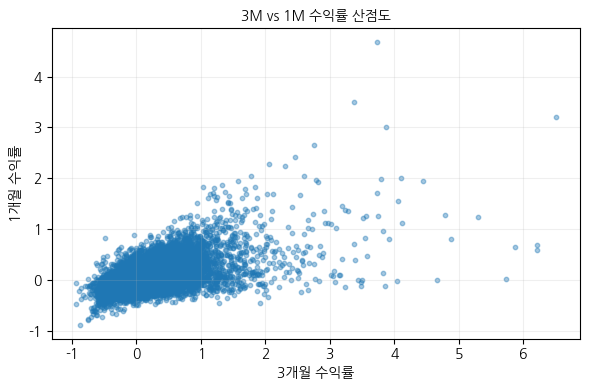

In [19]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# ─────────────────────────────────────────────────────────────────────────────
# 1) NanumGothic 폰트 경로 설정 (fm.findSystemFonts() 결과를 그대로 복사)
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# 2) Matplotlib 전역 폰트 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False
# ─────────────────────────────────────────────────────────────────────────────


# ─────────────────────────────────────────────────────────────────────────────
# 3) 실제 데이터 로드 및 그래프 예시 (필요에 따라 이 아래에 본인의 코드를 이어 붙이세요)
# ----------------------------------------
# 예) 종목별 기준월 데이터 불러오기
file_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'  # 실제 경로로 변경
df = pd.read_csv(file_path, parse_dates=['기준월'])

# 예) 간단한 산점도 그리기
# (예시 목적으로 '3개월수익률'과 '1개월수익률' 컬럼이 있다고 가정)
if '3개월수익률' in df.columns and '1개월수익률' in df.columns:
    df_plot = df.dropna(subset=['3개월수익률', '1개월수익률'])
    plt.figure(figsize=(6, 4))
    plt.scatter(
        df_plot['3개월수익률'],
        df_plot['1개월수익률'],
        s=10, alpha=0.4
    )
    plt.xlabel('3개월 수익률', fontproperties=font_prop)
    plt.ylabel('1개월 수익률', fontproperties=font_prop)
    plt.title('3M vs 1M 수익률 산점도', fontproperties=font_prop)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
# ─────────────────────────────────────────────────────────────────────────────


=== [유효성 검증] 6개월 모멘텀(ret_6m) ===


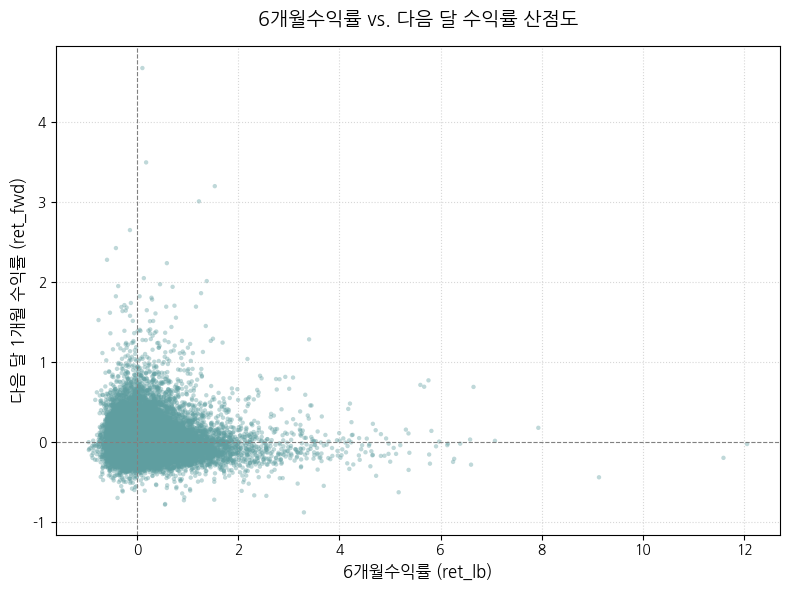

>>> 6개월수익률 vs. 다음 달 1개월 수익률 상관계수 (Pearson): -0.0281  (p-value=0.0000)


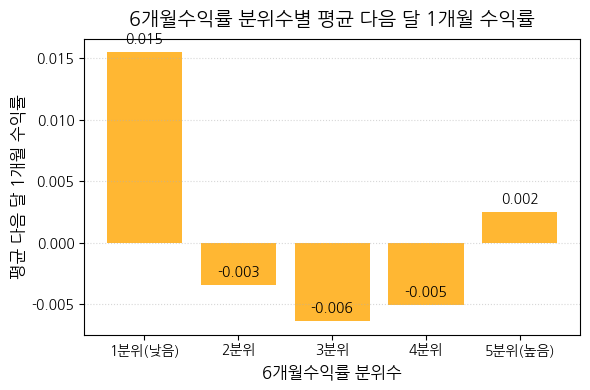


=== [유효성 검증] 12개월 모멘텀(ret_12m) ===


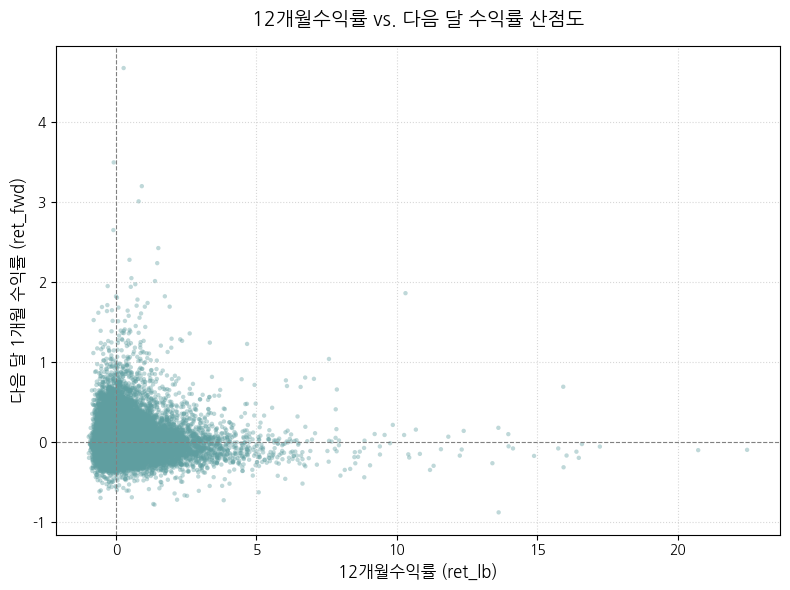

>>> 12개월수익률 vs. 다음 달 1개월 수익률 상관계수 (Pearson): -0.0149  (p-value=0.0001)


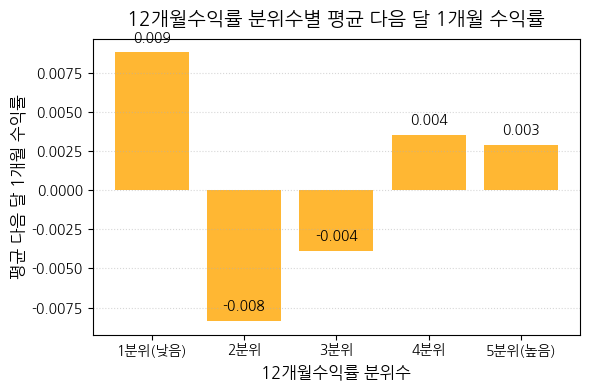


--- 분위수별 평균 다음 달 1개월 수익률 (6개월 모멘텀) ---
quantile_label  mean_forward_ret
       1분위(낮음)          0.015484
           2분위         -0.003482
           3분위         -0.006405
           4분위         -0.005100
       5분위(높음)          0.002493

--- 분위수별 평균 다음 달 1개월 수익률 (12개월 모멘텀) ---
quantile_label  mean_forward_ret
       1분위(낮음)          0.008807
           2분위         -0.008380
           3분위         -0.003864
           4분위          0.003540
       5분위(높음)          0.002887


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr

# -------------------------------------------------------------
# 1) 한글 폰트 설정 (필요하다면 본인 환경에 맞게 수정하세요)
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# 2) Matplotlib 전역 폰트 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False


# -------------------------------------------------------------
# 2) 데이터 로드 및 '기준월' 파싱 수정
# -------------------------------------------------------------
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)

# 기존에 format='%Y-%m'을 사용하면 '2021-01-01'처럼 '-01'이 붙은 문자열이 제대로 파싱되지 않아 에러가 발생합니다.
# 따라서 format을 지정하지 않고 pd.to_datetime만 사용하여 읽은 뒤, 월(Period 'M')로 변환합니다.
df['기준월'] = pd.to_datetime(df['기준월']) \
                .dt.to_period('M') \
                .dt.to_timestamp()

# -------------------------------------------------------------
# 3) 필수 칼럼 유무 확인
# -------------------------------------------------------------
required_cols = ['기준월', '종목코드', '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률']
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"'{c}' 컬럼이 없습니다. 데이터셋을 확인해주세요.")

# -------------------------------------------------------------
# 4) “다음 달 1개월 수익률(ret_forward_1m)” 생성
# -------------------------------------------------------------
#  1) 종목코드별로 오름차순 정렬
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

#  2) 그룹별로 1개월수익률을 shift(-1) → 다음 달 수익률
df['ret_forward_1m'] = df.groupby('종목코드')['1개월수익률'].shift(-1)

#  3) 다음 달 수익률이 없는(= NaN) 마지막 달들은 분석에서 제외
df = df.dropna(subset=['ret_forward_1m']).reset_index(drop=True)


# -------------------------------------------------------------
# 5) 유효성 검증 함수 정의
# -------------------------------------------------------------
def validate_momentum(df, lookback_col, num_bins=5):
    """
    lookback_col: '6개월수익률' 또는 '12개월수익률'
    num_bins    : 분위수를 몇 개(quintile=5)로 나눌지

    1) 산점도 (lookback vs. 다음 달 수익률)
    2) 피어슨 상관계수 계산
    3) 분위수(quintile)별 평균 다음 달 수익률 바 차트
    """
    # (1) 필요한 칼럼만 추출하고 이름 변경
    tmp = df[['기준월', '종목코드', lookback_col, 'ret_forward_1m']] \
            .dropna() \
            .copy() \
            .rename(columns={lookback_col: 'ret_lb', 'ret_forward_1m': 'ret_fwd'})

    # (2) 산점도 그리기
    plt.figure(figsize=(8, 6))
    plt.scatter(tmp['ret_lb'], tmp['ret_fwd'], alpha=0.4, s=10, color='cadetblue', edgecolor='none')
    plt.axhline(0, color='gray', lw=0.8, linestyle='--')
    plt.axvline(0, color='gray', lw=0.8, linestyle='--')
    plt.xlabel(f"{lookback_col} (ret_lb)", fontsize=12)
    plt.ylabel("다음 달 1개월 수익률 (ret_fwd)", fontsize=12)
    plt.title(f"{lookback_col} vs. 다음 달 수익률 산점도", fontsize=14, pad=15)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # (3) 피어슨 상관계수 계산
    corr_val, pval = pearsonr(tmp['ret_lb'], tmp['ret_fwd'])
    print(f">>> {lookback_col} vs. 다음 달 1개월 수익률 상관계수 (Pearson): {corr_val:.4f}  (p-value={pval:.4f})")

    # (4) ret_lb를 분위수(quintile)로 나누고 평균 ret_fwd 계산
    tmp['quantile'] = pd.qcut(tmp['ret_lb'], q=num_bins, labels=False)
    agg = tmp.groupby('quantile')['ret_fwd'].mean().reset_index()
    label_map = {
        0: '1분위(낮음)',
        1: '2분위',
        2: '3분위',
        3: '4분위',
        4: '5분위(높음)'
    }
    agg['quantile_label'] = agg['quantile'].map(label_map)

    # (5) 바 차트 그리기
    plt.figure(figsize=(6, 4))
    bars = plt.bar(agg['quantile_label'], agg['ret_fwd'], color='orange', alpha=0.8)
    for rect, val in zip(bars, agg['ret_fwd']):
        plt.text(
            rect.get_x() + rect.get_width() / 2,
            val + 0.0005,
            f"{val:.3f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
    plt.xlabel(f"{lookback_col} 분위수", fontsize=12)
    plt.ylabel("평균 다음 달 1개월 수익률", fontsize=12)
    plt.title(f"{lookback_col} 분위수별 평균 다음 달 1개월 수익률", fontsize=14, pad=10)
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # (6) 분위수별 결과 테이블 반환
    return agg[['quantile_label', 'ret_fwd']].rename(columns={'ret_fwd':'mean_forward_ret'})


# -------------------------------------------------------------
# 6) 실제 유효성 검증 실행: 6개월, 12개월 모멘텀
# -------------------------------------------------------------
print("\n=== [유효성 검증] 6개월 모멘텀(ret_6m) ===")
agg_6m = validate_momentum(df, lookback_col='6개월수익률', num_bins=5)

print("\n=== [유효성 검증] 12개월 모멘텀(ret_12m) ===")
agg_12m = validate_momentum(df, lookback_col='12개월수익률', num_bins=5)


# -------------------------------------------------------------
# 7) 결과 요약 콘솔 출력 (Optional)
# -------------------------------------------------------------
print("\n--- 분위수별 평균 다음 달 1개월 수익률 (6개월 모멘텀) ---")
print(agg_6m.to_string(index=False))

print("\n--- 분위수별 평균 다음 달 1개월 수익률 (12개월 모멘텀) ---")
print(agg_12m.to_string(index=False))

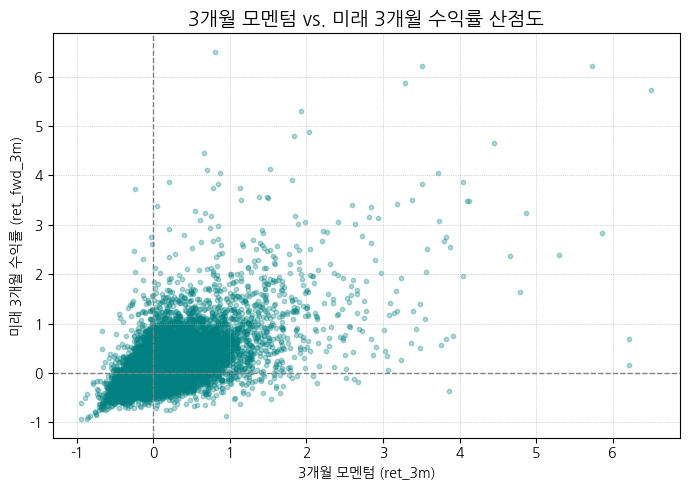

>>> 3개월수익률 vs. 미래 3개월 수익률 상관계수 (Pearson): 0.6389  (p-value=0.0000)

--- 분위수별 평균 미래 3개월 수익률 (ret_fwd_3m) ---
quantile_5  mean_forward_3m
   1분위(낮음)        -0.155615
       2분위        -0.073027
       3분위        -0.023466
       4분위         0.040315
   5분위(높음)         0.248492


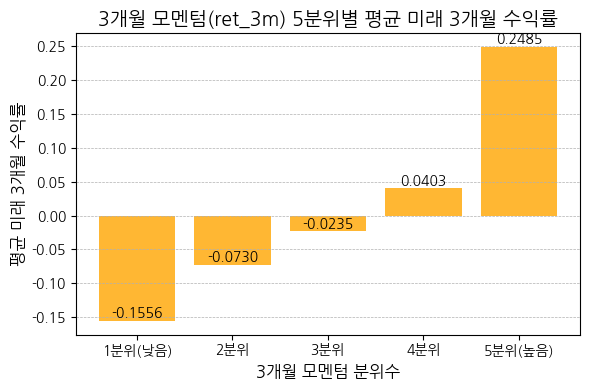

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from scipy.stats import pearsonr

# ───────────────────────────────────────────────────────────────────
# 1) 한글 폰트 설정 (필요시 자신의 경로에 맞게 수정)
# ───────────────────────────────────────────────────────────────────
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# 2) Matplotlib 전역 폰트 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# ───────────────────────────────────────────────────────────────────
# 2) 데이터 로드 및 전처리
# ───────────────────────────────────────────────────────────────────
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'  # ← 실제 파일 경로로 수정
df = pd.read_csv(csv_path)

# 2-1) '기준월' 컬럼을 datetime으로 변환 (YYYY-MM, 또는 YYYY-MM-DD 형식에 맞춰 조정)
#      예제에서는 "YYYY-MM-01" 형식이라고 가정하고 to_datetime을 사용
df['기준월'] = pd.to_datetime(df['기준월'], errors='coerce')  # 자동 파싱

# 2-2) 필수 컬럼이 있는지 확인
required = ['기준월','종목코드','3개월수익률']
for col in required:
    if col not in df.columns:
        raise ValueError(f"필수 컬럼 '{col}' 이(가) 없습니다.")

# 2-3) 컬럼명 간소화 (편의상 '3개월수익률'을 ret_3m으로 줄입니다)
df = df.rename(columns={'3개월수익률':'ret_3m'})

# 2-4) 종목별로 날짜 정렬
df = df.sort_values(['종목코드','기준월']).reset_index(drop=True)

# 2-5) 종목별 “미래 3개월 수익률” ret_fwd_3m 계산
#      -> 동일 종목코드 내에서 ret_3m 컬럼을 한 칸 앞(미래)으로 shift
#      (예) 2021-01-01의 ret_3m 값은 “지난 3개월 수익률(2020-11~2020-12~2021-01)”,
#           ret_fwd_3m은 “2021-02~2021-03~2021-04” 기간의 ret_3m이 할당됨
df['ret_fwd_3m'] = df.groupby('종목코드')['ret_3m'].shift(-1)

# 2-6) NaN 제거: 현재 순간에 과거 3개월 수익률(ret_3m)과 미래 3개월(ret_fwd_3m)의 쌍이 있는 행만 남김
df_clean = df.dropna(subset=['ret_3m','ret_fwd_3m']).copy()


# ───────────────────────────────────────────────────────────────────
# 3) 산점도 & Pearson 상관계수 계산
# ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(7,5))
plt.scatter(df_clean['ret_3m'], df_clean['ret_fwd_3m'],
            s=10, alpha=0.3, color='teal')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('3개월 모멘텀 (ret_3m)')
plt.ylabel('미래 3개월 수익률 (ret_fwd_3m)')
plt.title('3개월 모멘텀 vs. 미래 3개월 수익률 산점도', fontsize=14)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# Pearson 상관계수 & p-value
corr, pval = pearsonr(df_clean['ret_3m'], df_clean['ret_fwd_3m'])
print(f">>> 3개월수익률 vs. 미래 3개월 수익률 상관계수 (Pearson): {corr:.4f}  (p-value={pval:.4f})")


# ───────────────────────────────────────────────────────────────────
# 4) 분위수별(5분위) 평균 “미래 3개월” 수익률 계산
# ───────────────────────────────────────────────────────────────────
# 4-1) ret_3m 기준으로 5분위 라벨 생성
df_clean['quantile_5'] = pd.qcut(df_clean['ret_3m'], 5,
                                  labels=['1분위(낮음)','2분위','3분위','4분위','5분위(높음)'])

# 4-2) 분위수별 미래 3개월 평균 수익률 집계
quantile_summary = df_clean.groupby('quantile_5')['ret_fwd_3m'] \
                           .mean() \
                           .reset_index() \
                           .rename(columns={'ret_fwd_3m':'mean_forward_3m'})

print("\n--- 분위수별 평균 미래 3개월 수익률 (ret_fwd_3m) ---")
print(quantile_summary.to_string(index=False))


# 4-3) 막대차트로 표시
plt.figure(figsize=(6,4))
bars = plt.bar(quantile_summary['quantile_5'],
               quantile_summary['mean_forward_3m'],
               color='orange', alpha=0.8)
plt.ylabel('평균 미래 3개월 수익률', fontsize=12)
plt.xlabel('3개월 모멘텀 분위수', fontsize=12)
plt.title('3개월 모멘텀(ret_3m) 5분위별 평균 미래 3개월 수익률', fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# 각 막대 위에 수치 표시
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.001,
             f"{h:.4f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



##########  분석 시작: 1개월수익률  →  ret_fwd_1m ##########



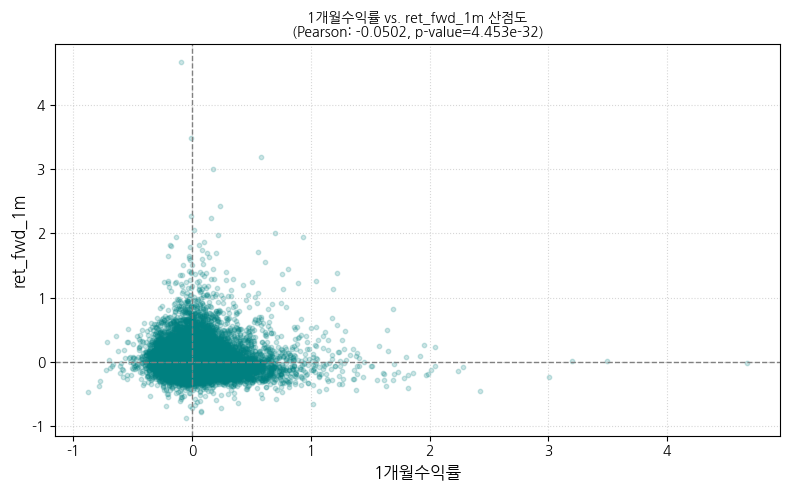

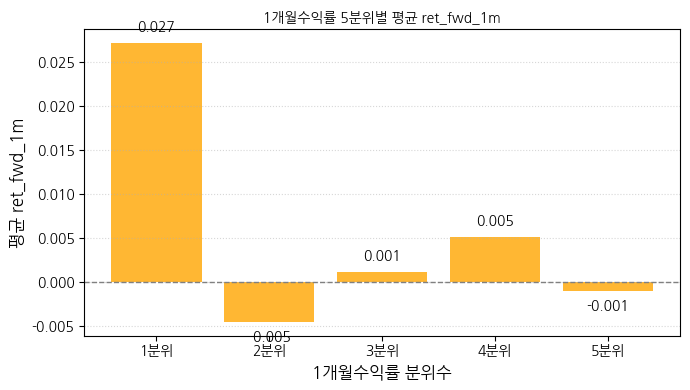

>>> 1개월수익률 vs. ret_fwd_1m 상관계수 (Pearson): -0.0502  (p-value=4.453e-32)

--- 분위수별 평균 (ret_fwd_1m) ---
1개월수익률_quantile  mean_ret_fwd_1m
            1분위         0.027113
            2분위        -0.004530
            3분위         0.001108
            4분위         0.005094
            5분위        -0.001017




##########  분석 시작: 1개월수익률  →  ret_fwd_3m ##########



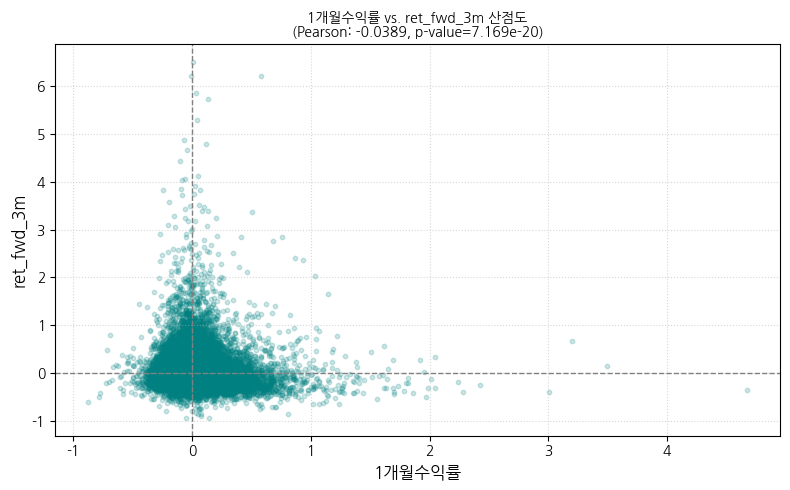

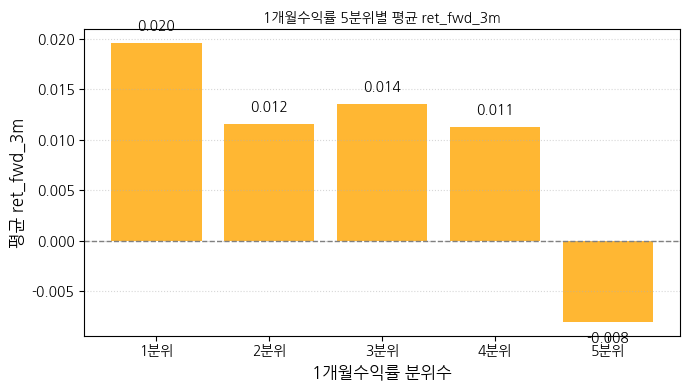

>>> 1개월수익률 vs. ret_fwd_3m 상관계수 (Pearson): -0.0389  (p-value=7.169e-20)

--- 분위수별 평균 (ret_fwd_3m) ---
1개월수익률_quantile  mean_ret_fwd_3m
            1분위         0.019578
            2분위         0.011576
            3분위         0.013565
            4분위         0.011264
            5분위        -0.008036




##########  분석 시작: 1개월수익률  →  ret_fwd_6m ##########



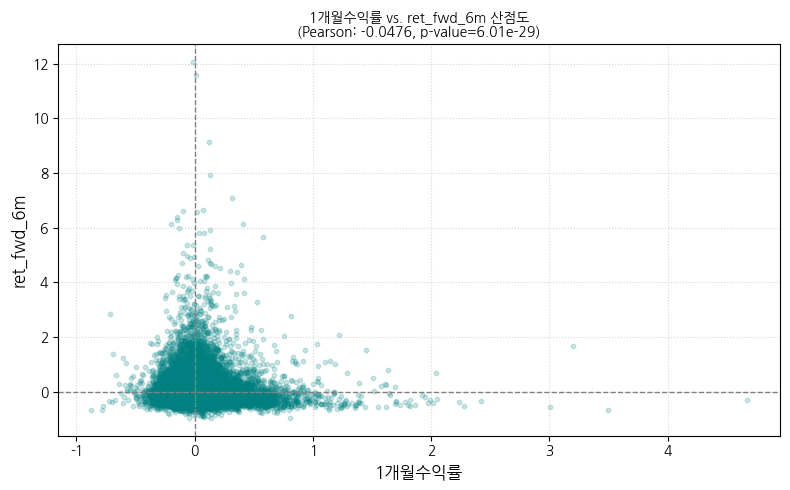

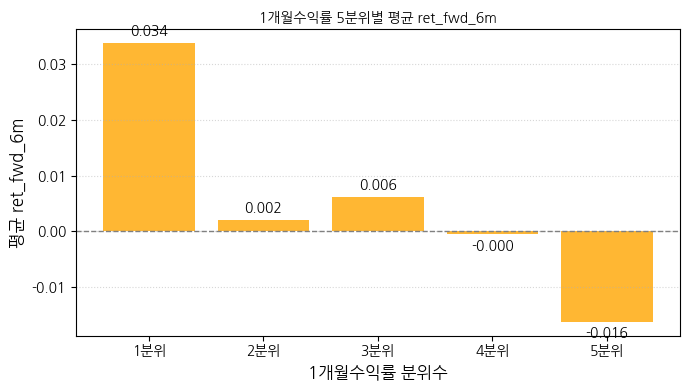

>>> 1개월수익률 vs. ret_fwd_6m 상관계수 (Pearson): -0.0476  (p-value=6.01e-29)

--- 분위수별 평균 (ret_fwd_6m) ---
1개월수익률_quantile  mean_ret_fwd_6m
            1분위         0.033762
            2분위         0.001992
            3분위         0.006100
            4분위        -0.000463
            5분위        -0.016219




##########  분석 시작: 1개월수익률  →  ret_fwd_12m ##########



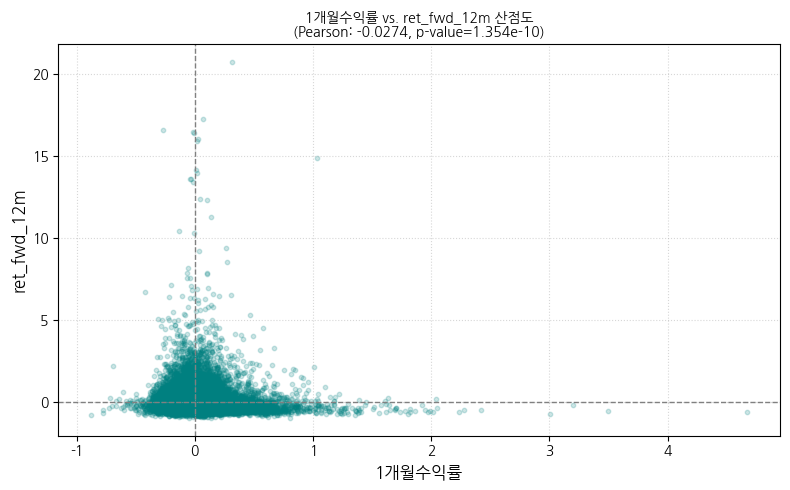

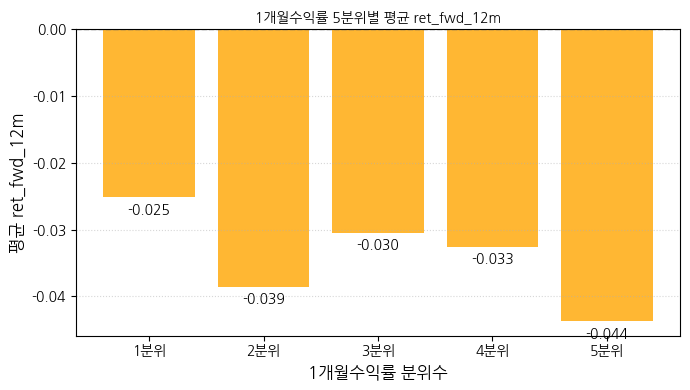

>>> 1개월수익률 vs. ret_fwd_12m 상관계수 (Pearson): -0.0274  (p-value=1.354e-10)

--- 분위수별 평균 (ret_fwd_12m) ---
1개월수익률_quantile  mean_ret_fwd_12m
            1분위         -0.025140
            2분위         -0.038551
            3분위         -0.030462
            4분위         -0.032536
            5분위         -0.043697




##########  분석 시작: 3개월수익률  →  ret_fwd_1m ##########



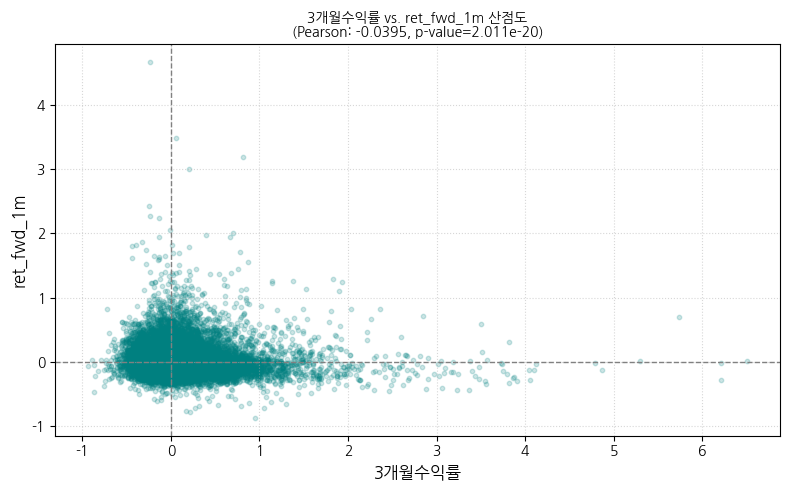

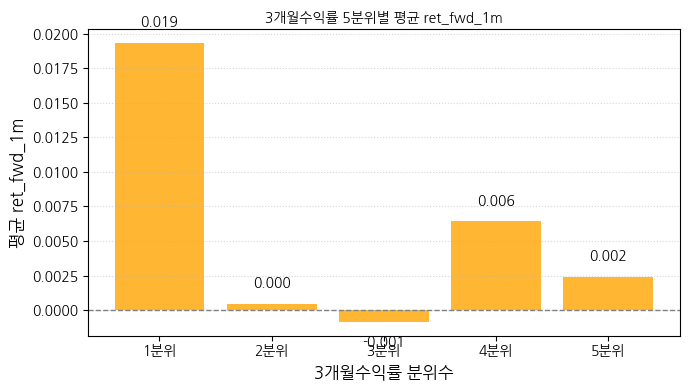

>>> 3개월수익률 vs. ret_fwd_1m 상관계수 (Pearson): -0.0395  (p-value=2.011e-20)

--- 분위수별 평균 (ret_fwd_1m) ---
3개월수익률_quantile  mean_ret_fwd_1m
            1분위         0.019304
            2분위         0.000461
            3분위        -0.000835
            4분위         0.006421
            5분위         0.002423




##########  분석 시작: 3개월수익률  →  ret_fwd_3m ##########



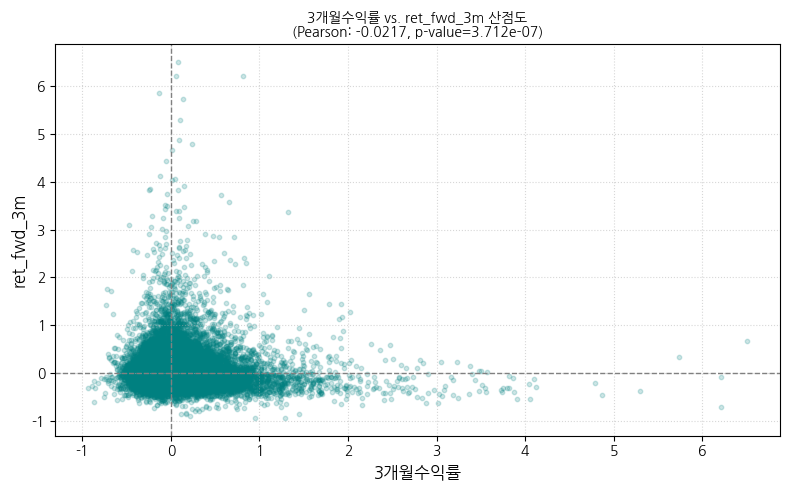

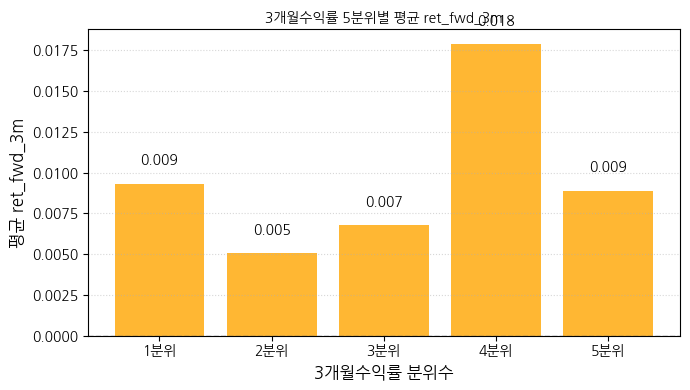

>>> 3개월수익률 vs. ret_fwd_3m 상관계수 (Pearson): -0.0217  (p-value=3.712e-07)

--- 분위수별 평균 (ret_fwd_3m) ---
3개월수익률_quantile  mean_ret_fwd_3m
            1분위         0.009320
            2분위         0.005056
            3분위         0.006784
            4분위         0.017903
            5분위         0.008893




##########  분석 시작: 3개월수익률  →  ret_fwd_6m ##########



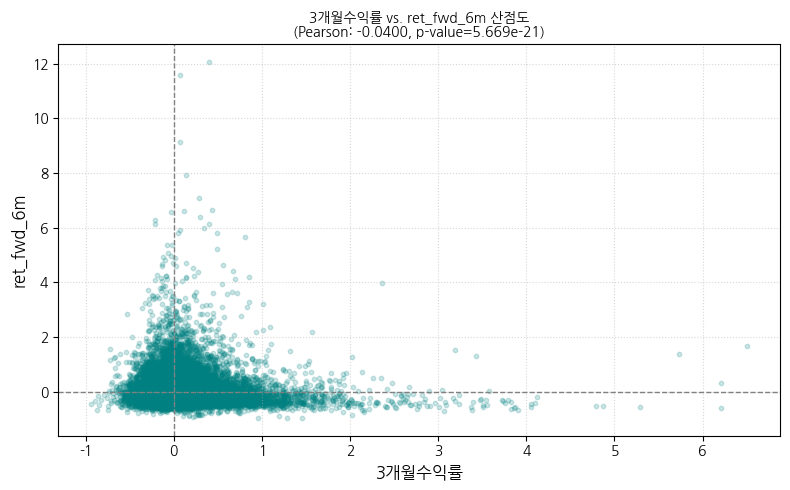

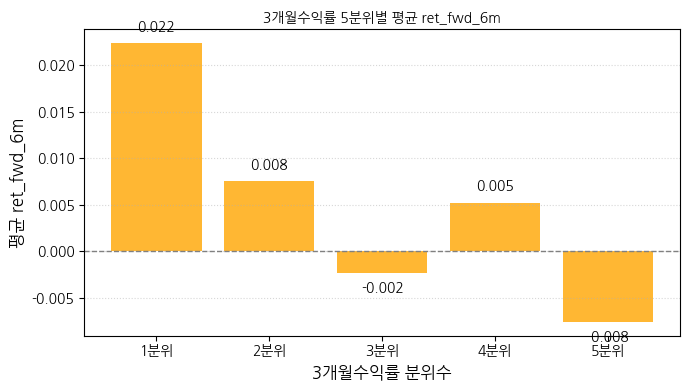

>>> 3개월수익률 vs. ret_fwd_6m 상관계수 (Pearson): -0.0400  (p-value=5.669e-21)

--- 분위수별 평균 (ret_fwd_6m) ---
3개월수익률_quantile  mean_ret_fwd_6m
            1분위         0.022342
            2분위         0.007524
            3분위        -0.002316
            4분위         0.005205
            5분위        -0.007571




##########  분석 시작: 3개월수익률  →  ret_fwd_12m ##########



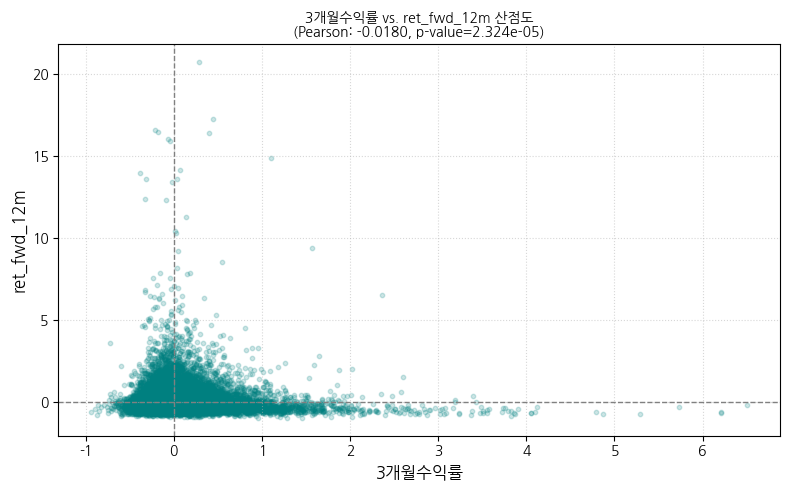

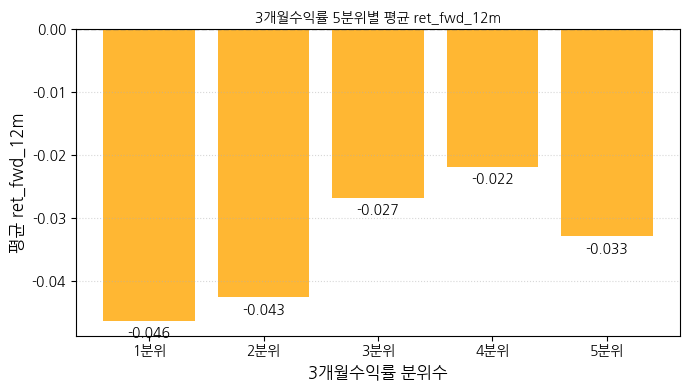

>>> 3개월수익률 vs. ret_fwd_12m 상관계수 (Pearson): -0.0180  (p-value=2.324e-05)

--- 분위수별 평균 (ret_fwd_12m) ---
3개월수익률_quantile  mean_ret_fwd_12m
            1분위         -0.046343
            2분위         -0.042563
            3분위         -0.026733
            4분위         -0.021864
            5분위         -0.032875




##########  분석 시작: 6개월수익률  →  ret_fwd_1m ##########



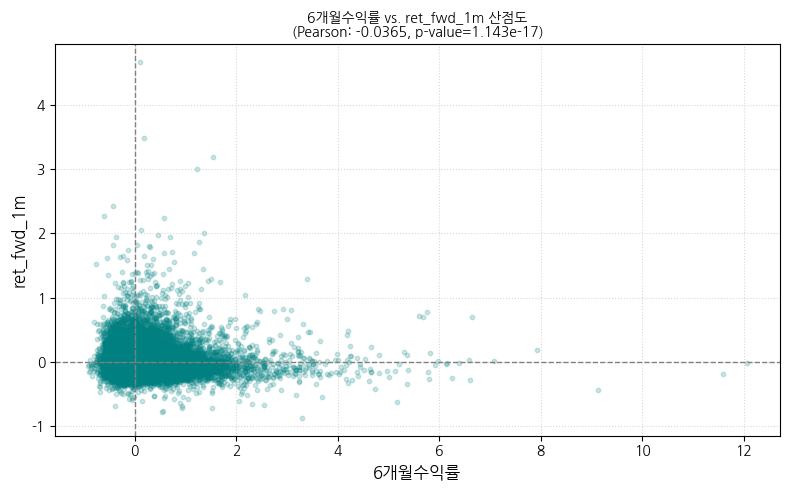

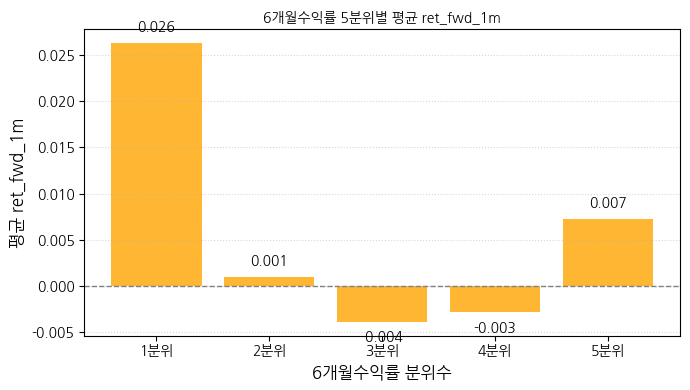

>>> 6개월수익률 vs. ret_fwd_1m 상관계수 (Pearson): -0.0365  (p-value=1.143e-17)

--- 분위수별 평균 (ret_fwd_1m) ---
6개월수익률_quantile  mean_ret_fwd_1m
            1분위         0.026237
            2분위         0.000984
            3분위        -0.003856
            4분위        -0.002834
            5분위         0.007245




##########  분석 시작: 6개월수익률  →  ret_fwd_3m ##########



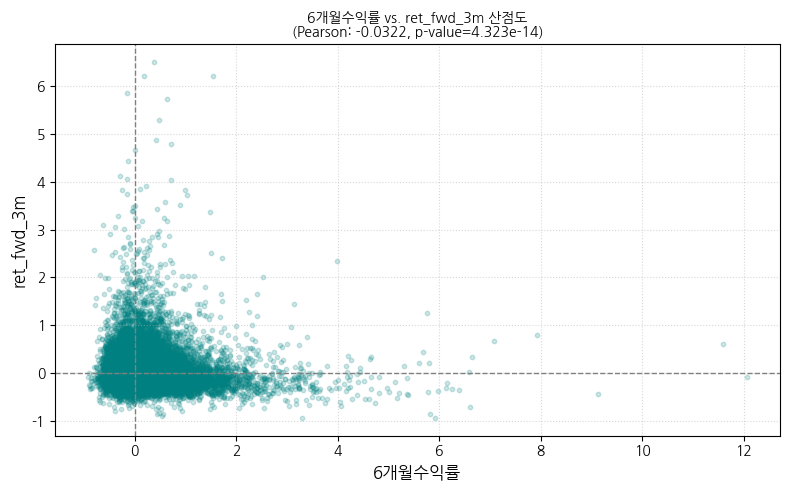

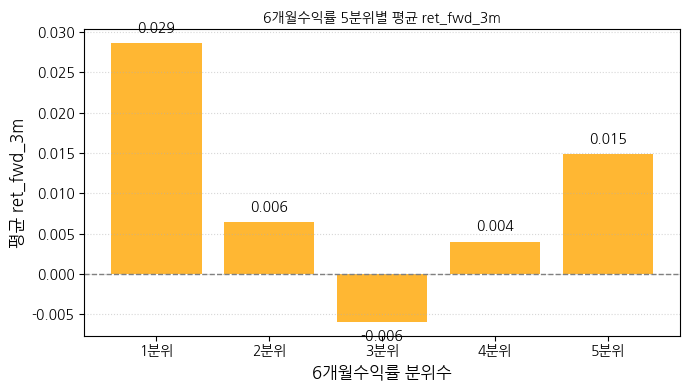

>>> 6개월수익률 vs. ret_fwd_3m 상관계수 (Pearson): -0.0322  (p-value=4.323e-14)

--- 분위수별 평균 (ret_fwd_3m) ---
6개월수익률_quantile  mean_ret_fwd_3m
            1분위         0.028598
            2분위         0.006467
            3분위        -0.005938
            4분위         0.004012
            5분위         0.014818




##########  분석 시작: 6개월수익률  →  ret_fwd_6m ##########



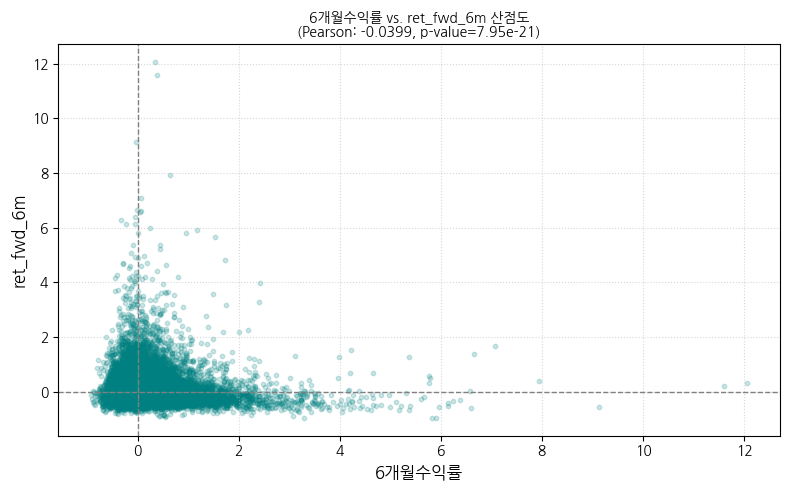

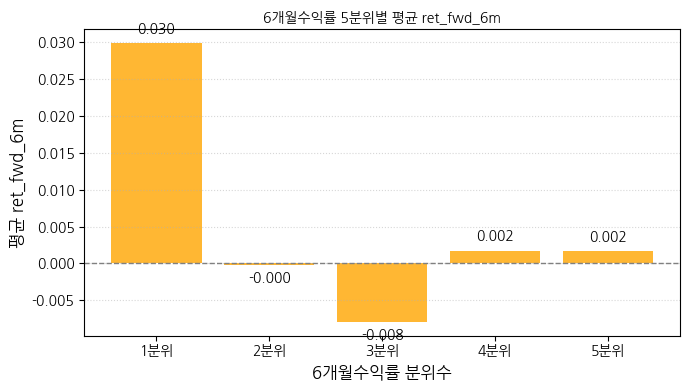

>>> 6개월수익률 vs. ret_fwd_6m 상관계수 (Pearson): -0.0399  (p-value=7.95e-21)

--- 분위수별 평균 (ret_fwd_6m) ---
6개월수익률_quantile  mean_ret_fwd_6m
            1분위         0.029854
            2분위        -0.000153
            3분위        -0.007917
            4분위         0.001725
            5분위         0.001674




##########  분석 시작: 6개월수익률  →  ret_fwd_12m ##########



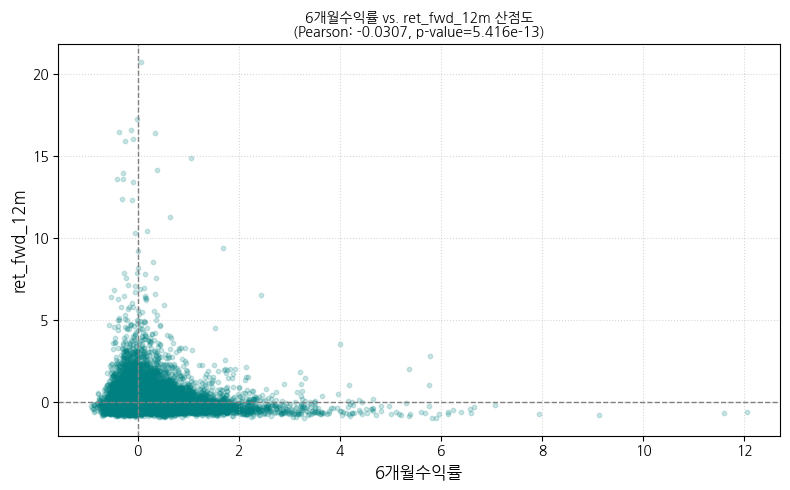

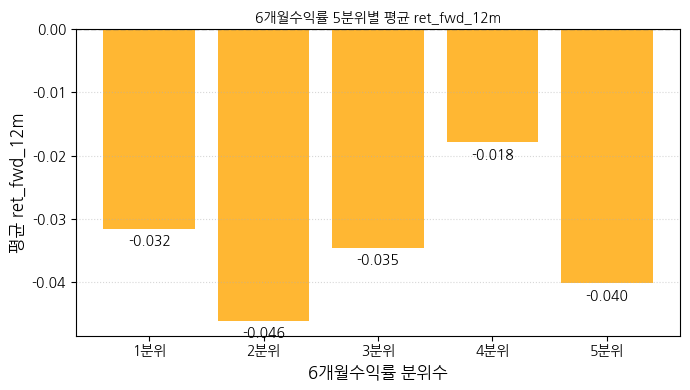

>>> 6개월수익률 vs. ret_fwd_12m 상관계수 (Pearson): -0.0307  (p-value=5.416e-13)

--- 분위수별 평균 (ret_fwd_12m) ---
6개월수익률_quantile  mean_ret_fwd_12m
            1분위         -0.031556
            2분위         -0.046159
            3분위         -0.034611
            4분위         -0.017869
            5분위         -0.040187




##########  분석 시작: 12개월수익률  →  ret_fwd_1m ##########



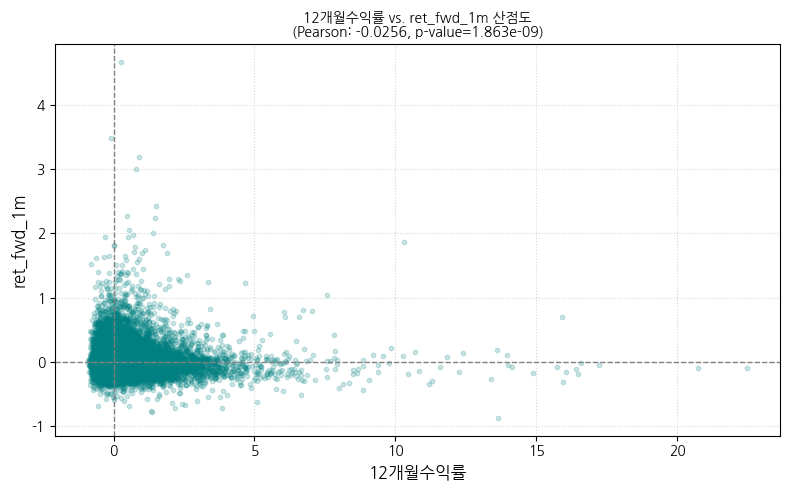

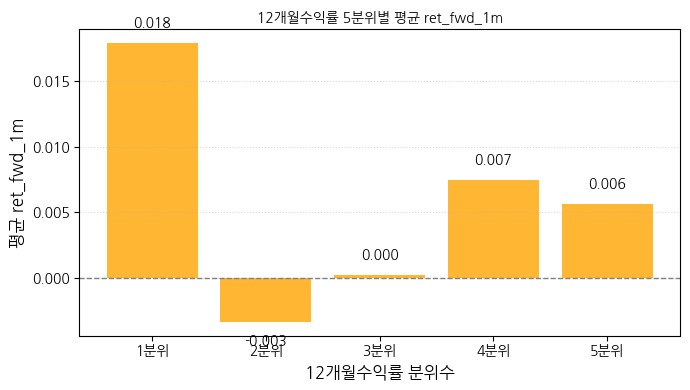

>>> 12개월수익률 vs. ret_fwd_1m 상관계수 (Pearson): -0.0256  (p-value=1.863e-09)

--- 분위수별 평균 (ret_fwd_1m) ---
12개월수익률_quantile  mean_ret_fwd_1m
             1분위         0.017927
             2분위        -0.003378
             3분위         0.000183
             4분위         0.007444
             5분위         0.005600




##########  분석 시작: 12개월수익률  →  ret_fwd_3m ##########



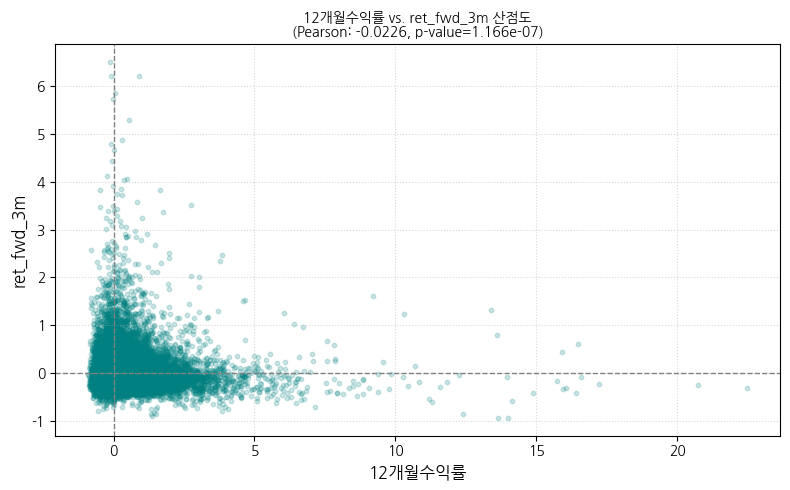

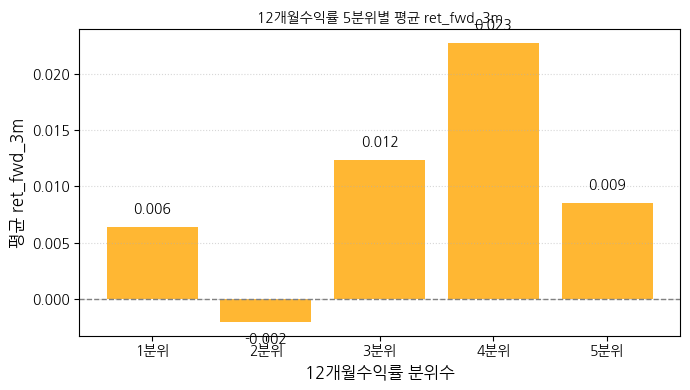

>>> 12개월수익률 vs. ret_fwd_3m 상관계수 (Pearson): -0.0226  (p-value=1.166e-07)

--- 분위수별 평균 (ret_fwd_3m) ---
12개월수익률_quantile  mean_ret_fwd_3m
             1분위         0.006376
             2분위        -0.001982
             3분위         0.012339
             4분위         0.022687
             5분위         0.008536




##########  분석 시작: 12개월수익률  →  ret_fwd_6m ##########



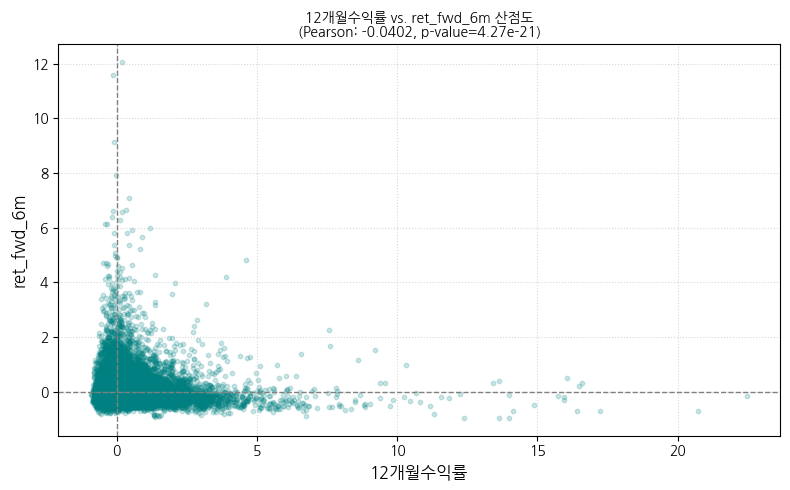

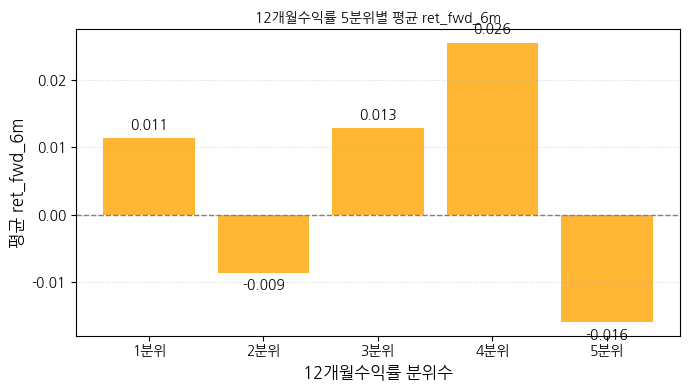

>>> 12개월수익률 vs. ret_fwd_6m 상관계수 (Pearson): -0.0402  (p-value=4.27e-21)

--- 분위수별 평균 (ret_fwd_6m) ---
12개월수익률_quantile  mean_ret_fwd_6m
             1분위         0.011340
             2분위        -0.008602
             3분위         0.012854
             4분위         0.025513
             5분위        -0.015920




##########  분석 시작: 12개월수익률  →  ret_fwd_12m ##########



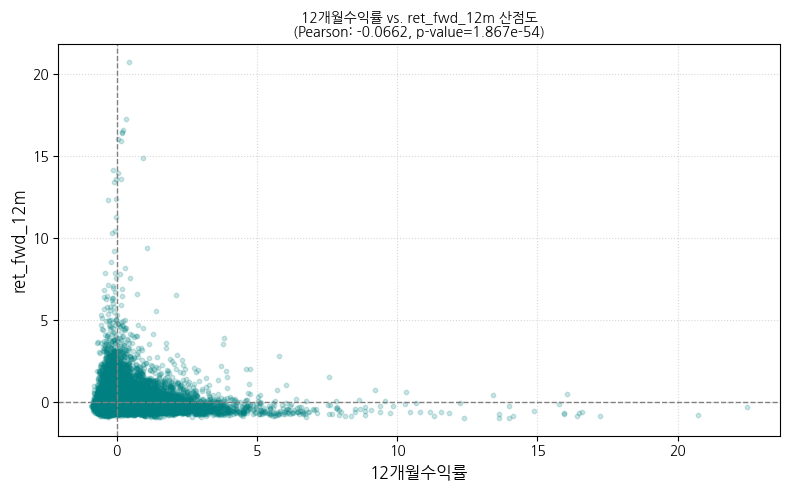

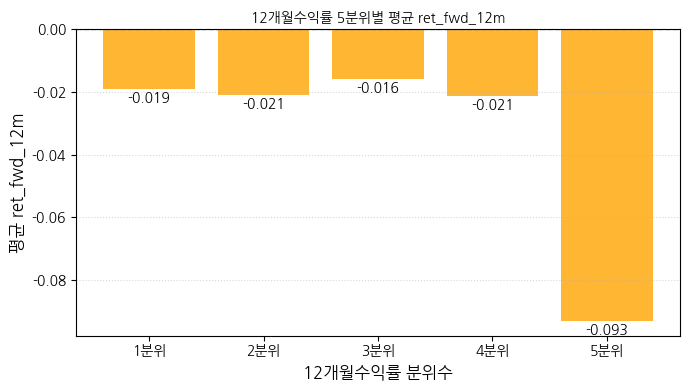

>>> 12개월수익률 vs. ret_fwd_12m 상관계수 (Pearson): -0.0662  (p-value=1.867e-54)

--- 분위수별 평균 (ret_fwd_12m) ---
12개월수익률_quantile  mean_ret_fwd_12m
             1분위         -0.019080
             2분위         -0.020942
             3분위         -0.015963
             4분위         -0.021347
             5분위         -0.093045




In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from scipy.stats import pearsonr

# =============================================
# 0) 한글 폰트 설정 (NanumGothic)
# =============================================
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# 2) Matplotlib 전역 폰트 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# =============================================
# 1) 데이터 로드 및 전처리
# =============================================
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'  # ← 본인 경로로 변경
df = pd.read_csv(csv_path)

# 1-1) '기준월'을 datetime으로 변환 (월 단위)
#      'YYYY-MM' 또는 'YYYY-MM-DD' 형태가 섞여 있을 수 있으므로 format 강제하지 않고 파싱
df['기준월'] = pd.to_datetime(df['기준월'], errors='coerce').dt.to_period('M').dt.to_timestamp()
if df['기준월'].isna().any():
    raise ValueError("‘기준월’ 컬럼에 유효하지 않은 날짜 문자열이 포함되어 있습니다.")

# 1-2) 필요한 컬럼 존재 여부 확인
required_cols = [
    '기준월', '종목코드',
    '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률'
]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"필수 컬럼 '{c}' 이(가) 없습니다. CSV를 확인하세요.")

# 1-3) 종목코드, 기준월 순으로 정렬
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

# =============================================
# 2) 미래(ret_fwd) 수익률 계산 함수 정의
# =============================================
def compute_forward_returns(df: pd.DataFrame, k_months: int, base_col: str = '1개월수익률') -> pd.Series:
    """
    각 종목코드별로, 'base_col'(예: '1개월수익률')을 사용하여
    앞으로 k개월 동안의 누적 수익률을 계산합니다.
    예) k_months=3 이면, ret_fwd_3m[i] = (1+ret_i+1M)*(1+ret_i+2M)*(1+ret_i+3M) - 1
    만약 i + k_months 까지 데이터가 없으면 NaN 반환.
    """
    forward = []

    # 각 종목코드별 그룹으로 순회
    for code, grp in df.groupby('종목코드', sort=False):
        # grp은 해당 종목의 행들이 시간순(기준월 오름차순)으로 정렬된 상태
        rets = grp[base_col].values  # 예: [0.02, -0.01, 0.05, ...]
        n = len(rets)
        fw = np.full(shape=n, fill_value=np.nan)

        # i 번째 index에서 i+1 ~ i+k_months 까지 누적(월별 단위 수익률 곱)
        for i in range(n):
            if i + k_months < n:
                cumulative = 1.0
                for j in range(1, k_months + 1):
                    cumulative *= (1 + rets[i + j])
                fw[i] = cumulative - 1.0
            else:
                fw[i] = np.nan

        forward.append(fw)

    # 그룹별로 모아진 배열을 다시 원본 DataFrame 인덱스 순서대로 합치기
    forward_all = np.concatenate([arr for arr in forward])
    return pd.Series(forward_all, index=df.index)


# 2-1) ret_fwd_1m ~ ret_fwd_12m 계산
df['ret_fwd_1m']  = compute_forward_returns(df, k_months=1,  base_col='1개월수익률')
df['ret_fwd_3m']  = compute_forward_returns(df, k_months=3,  base_col='1개월수익률')
df['ret_fwd_6m']  = compute_forward_returns(df, k_months=6,  base_col='1개월수익률')
df['ret_fwd_12m'] = compute_forward_returns(df, k_months=12, base_col='1개월수익률')

# 2-2) ret_fwd_¶m 컬럼이 제대로 생성되었는지 확인 (NaN이 전체가 아닌지 체크)
for col in ['ret_fwd_1m','ret_fwd_3m','ret_fwd_6m','ret_fwd_12m']:
    if df[col].notna().sum() == 0:
        raise RuntimeError(f"'{col}'가 모두 NaN입니다. 계산 로직을 확인하세요.")

# 2-3) 분석 편의상 ret_fwd, 과거 룩백 대비 target이 NaN인 행(마지막 몇 개)은 삭제
df = df.dropna(subset=[
    'ret_fwd_1m','ret_fwd_3m','ret_fwd_6m','ret_fwd_12m',
    '1개월수익률','3개월수익률','6개월수익률','12개월수익률'
]).copy()


# =============================================
# 3) “룩백 vs. 타깃” 분석 함수
# =============================================
def analyze_lookback_vs_target(
    df: pd.DataFrame,
    lookback_col: str,
    forward_col: str,
    n_quantiles: int = 5
):
    """
    1) lookback_col vs. forward_col에 대한 Scatter + Pearson 상관계수
    2) lookback_col을 n_quantiles 분위로 쪼개고,
       각 분위수별 forward_col 평균 계산 → Bar 차트
    결과: 2개의 플롯과 콘솔 출력을 순차적으로 보여줍니다.
    """
    x = df[lookback_col].values
    y = df[forward_col].values

    # 1-1) Pearson 상관계수 계산
    corr_coef, p_value = pearsonr(x, y)

    # 1-2) 산점도
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, s=10, alpha=0.2, color='teal')
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(
        f"{lookback_col} vs. {forward_col} 산점도\n"
        f"(Pearson: {corr_coef:.4f}, p-value={p_value:.4g})",
        fontsize=14, fontproperties=font_prop
    )
    plt.xlabel(lookback_col, fontsize=12, fontproperties=font_prop)
    plt.ylabel(forward_col, fontsize=12, fontproperties=font_prop)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 2) 분위수별 평균 계산 → Bar 차트
    #   예: “3분위” 대신 “3분위(낮음↑높음)” 식의 라벨로 표기할 수 있지만,
    #   여기서는 단순히 “1분위, 2분위, … 5분위” 로 둡니다.
    quantile_labels = [f"{i}분위" for i in range(1, n_quantiles + 1)]
    # pd.qcut은 같은 값이 많을 때 균등 분할이 안 될 수 있으니 duplicates='drop' 옵션을 추가
    df[f"{lookback_col}_quantile"] = pd.qcut(
        df[lookback_col],
        q=n_quantiles,
        labels=quantile_labels,
        duplicates='drop'
    )

    quantile_summary = (
        df.groupby(f"{lookback_col}_quantile")[forward_col]
          .mean()
          .rename("mean_" + forward_col)
          .reset_index()
    )

    plt.figure(figsize=(7, 4))
    bars = plt.bar(
        quantile_summary[f"{lookback_col}_quantile"],
        quantile_summary["mean_" + forward_col],
        color='orange', alpha=0.8
    )
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(
        f"{lookback_col} 5분위별 평균 {forward_col}",
        fontsize=14, fontproperties=font_prop
    )
    plt.xlabel(f"{lookback_col} 분위수", fontsize=12, fontproperties=font_prop)
    plt.ylabel(f"평균 {forward_col}", fontsize=12, fontproperties=font_prop)
    plt.grid(axis='y', linestyle=':', alpha=0.5)

    # Bar 위에 평균값 숫자 표시
    for rect, mean_val in zip(bars, quantile_summary["mean_" + forward_col]):
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.001 * np.sign(height),
            f"{mean_val:.3f}",
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=10
        )
    plt.tight_layout()
    plt.show()

    # 콘솔에 상관계수와 분위수별 평균 값 출력
    print(f">>> {lookback_col} vs. {forward_col} 상관계수 (Pearson): {corr_coef:.4f}  (p-value={p_value:.4g})")
    print("\n--- 분위수별 평균 ({forward_col}) ---".replace("{forward_col}", forward_col))
    print(quantile_summary.to_string(index=False))
    print("\n" + ("=" * 60) + "\n")


# =============================================
# 4) “룩백 1,3,6,12 vs. 타깃 1,3,6,12” 전부 순회하기
# =============================================
lookback_cols = ['1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률']
forward_cols  = ['ret_fwd_1m',    'ret_fwd_3m',    'ret_fwd_6m',    'ret_fwd_12m']

for lb in lookback_cols:
    for fw in forward_cols:
        print(f"\n\n##########  분석 시작: {lb}  →  {fw} ##########\n")
        analyze_lookback_vs_target(df, lookback_col=lb, forward_col=fw, n_quantiles=5)

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from scipy.stats import pearsonr
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================
font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# 2) Matplotlib 전역 폰트 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# =============================================
# 1) 데이터 로드 및 전처리
# =============================================
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'  # ← 실제 경로로 수정
df = pd.read_csv(csv_path)

# 1-1) '기준월'을 datetime으로 변환 → 'yyyy-mm' 혹은 'yyyy-mm-dd' 형태 모두 대응
df['기준월'] = pd.to_datetime(df['기준월'], errors='coerce').dt.to_period('M').dt.to_timestamp()
if df['기준월'].isna().any():
    raise ValueError("‘기준월’ 컬럼 파싱 중 NaT가 발생했습니다. CSV를 점검해주세요.")

# 1-2) 필수 컬럼 확인
required_cols = [
    '기준월', '종목코드',
    '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률'
]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"필수 컬럼 '{col}' 이(가) 없습니다. CSV를 확인하세요.")

# 1-3) 종목코드+기준월 기준으로 오름차순 정렬
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

# =============================================
# 2) 미래 수익률(ret_fwd_... ) 계산 함수
# =============================================
def compute_forward_returns(df: pd.DataFrame, k_months: int, base_col: str = '1개월수익률') -> pd.Series:
    """
    종목코드별로 base_col(월별 수익률)을 사용해 k개월 누적 수익률을 계산합니다.
    예: k_months=3 이면 ret_fwd_3m[i] = (1+ret[i+1])*(1+ret[i+2])*(1+ret[i+3]) - 1
    """
    result = []
    # 종목별 그룹 순회 (기준월 오름차순 유지된 상태)
    for code, grp in df.groupby('종목코드', sort=False):
        rets = grp[base_col].values
        n = len(rets)
        fw = np.full(n, np.nan)
        for i in range(n):
            if i + k_months < n:
                prod = 1.0
                for j in range(1, k_months + 1):
                    prod *= (1 + rets[i + j])
                fw[i] = prod - 1.0
            else:
                fw[i] = np.nan
        result.append(fw)
    return pd.Series(np.concatenate(result), index=df.index)

# 2-1) ret_fwd_1m, ret_fwd_3m, ret_fwd_6m, ret_fwd_12m 생성
df['ret_fwd_1m']  = compute_forward_returns(df, k_months=1,  base_col='1개월수익률')
df['ret_fwd_3m']  = compute_forward_returns(df, k_months=3,  base_col='1개월수익률')
df['ret_fwd_6m']  = compute_forward_returns(df, k_months=6,  base_col='1개월수익률')
df['ret_fwd_12m'] = compute_forward_returns(df, k_months=12, base_col='1개월수익률')

# 2-2) NaN 제거
df = df.dropna(subset=[
    'ret_fwd_1m', 'ret_fwd_3m', 'ret_fwd_6m', 'ret_fwd_12m',
    '1개월수익률','3개월수익률','6개월수익률','12개월수익률'
]).reset_index(drop=True)

# =============================================
# 3) 요약 계산: “룩백 × 타깃” 지표 모아서 DataFrame으로 반환
# =============================================
lookback_cols = ['1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률']
forward_cols  = ['ret_fwd_1m',      'ret_fwd_3m',      'ret_fwd_6m',      'ret_fwd_12m']

summary_list = []

for lb in lookback_cols:
    # 분위수 라벨(5분위)
    quantile_labels = ['1분위(낮음)', '2분위', '3분위', '4분위', '5분위(높음)']

    # 먼저 lookback 컬럼을 5분위로 쪼개기 (중복값이 많은 경우 drop)
    df[f"{lb}_quantile"] = pd.qcut(
        df[lb],
        q=5,
        labels=quantile_labels,
        duplicates='drop'
    )

    for fw in forward_cols:
        # 1) Pearson 상관계수 계산
        x = df[lb].values
        y = df[fw].values
        corr_coef, p_val = pearsonr(x, y)

        # 2) 분위수별 평균 future return 계산
        grouped = df.groupby(f"{lb}_quantile")[fw].mean().reset_index()
        # grouped DataFrame이 “lb_quantile” 순으로 정렬되어 있다고 가정
        # (만약 순서가 깨져 있다면 sort_values(by=f"{lb}_quantile", ...) 필요)
        bottom_q_mean = grouped.loc[grouped[f"{lb}_quantile"] == '1분위(낮음)', fw].values
        top_q_mean    = grouped.loc[grouped[f"{lb}_quantile"] == '5분위(높음)',  fw].values

        # 만약 “1분위” 또는 “5분위”가 qcut 과정에서 drop 되었다면 NaN 처리
        bottom_val = float(bottom_q_mean[0]) if len(bottom_q_mean) == 1 else np.nan
        top_val    = float(top_q_mean[0])    if len(top_q_mean)    == 1 else np.nan
        diff_tb    = top_val - bottom_val if (not np.isnan(top_val) and not np.isnan(bottom_val)) else np.nan

        # summary_list에 결과 추가
        summary_list.append({
            'lookback': lb,
            'forward':  fw,
            'pearson_corr':      corr_coef,
            'pearson_pval':      p_val,
            'bottom_1q_mean':    bottom_val,
            'top_5q_mean':       top_val,
            'diff_top_minus_bottom': diff_tb
        })

# =============================================
# 4) 최종 요약 DataFrame 생성 및 출력
# =============================================
corr_summary = pd.DataFrame(summary_list)

#컬럼 순서 재배열(가독성을 위해)
corr_summary = corr_summary[
    ['lookback', 'forward', 
     'pearson_corr', 'pearson_pval',
     'bottom_1q_mean', 'top_5q_mean', 'diff_top_minus_bottom']
]

# 보기 좋게 소수 4자리/3자리 정도로 반올림
corr_summary['pearson_corr'] = corr_summary['pearson_corr'].round(4)
corr_summary['pearson_pval'] = corr_summary['pearson_pval'].apply(lambda x: f"{x:.2e}")
corr_summary['bottom_1q_mean'] = corr_summary['bottom_1q_mean'].round(4)
corr_summary['top_5q_mean']    = corr_summary['top_5q_mean'].round(4)
corr_summary['diff_top_minus_bottom'] = corr_summary['diff_top_minus_bottom'].round(4)

# 인덱스 초기화
corr_summary = corr_summary.reset_index(drop=True)

# 최종 출력
print("\n=== 16개 룩백×타깃 조합 요약 ===\n")
print(corr_summary.to_string(index=False))

# 필요하다면 CSV로 저장도 가능
# corr_summary.to_csv('momentum_lookback_forward_summary.csv', index=False)


=== 16개 룩백×타깃 조합 요약 ===

lookback     forward  pearson_corr pearson_pval  bottom_1q_mean  top_5q_mean  diff_top_minus_bottom
  1개월수익률  ret_fwd_1m       -0.0502     4.45e-32          0.0271      -0.0010                -0.0281
  1개월수익률  ret_fwd_3m       -0.0389     7.17e-20          0.0196      -0.0080                -0.0276
  1개월수익률  ret_fwd_6m       -0.0476     6.01e-29          0.0338      -0.0162                -0.0500
  1개월수익률 ret_fwd_12m       -0.0274     1.35e-10         -0.0251      -0.0437                -0.0186
  3개월수익률  ret_fwd_1m       -0.0395     2.01e-20          0.0193       0.0024                -0.0169
  3개월수익률  ret_fwd_3m       -0.0217     3.71e-07          0.0093       0.0089                -0.0004
  3개월수익률  ret_fwd_6m       -0.0400     5.67e-21          0.0223      -0.0076                -0.0299
  3개월수익률 ret_fwd_12m       -0.0180     2.32e-05         -0.0463      -0.0329                 0.0135
  6개월수익률  ret_fwd_1m       -0.0365     1.14e-17          0.0262       0.00

=== 리밸 주기별 Top20 포트폴리오 성과 (룩백=3M → 타깃=3M) ===
               Cumulative      CAGR    Sharpe       MDD
Rebalance (M)                                          
1               -0.736938 -0.283833 -1.196098 -0.748579
3               -0.607057 -0.208260 -1.831631 -0.619173
6               -0.436742 -0.133683 -1.487064 -0.542367
12              -0.454821 -0.140720 -3.055784 -0.470829


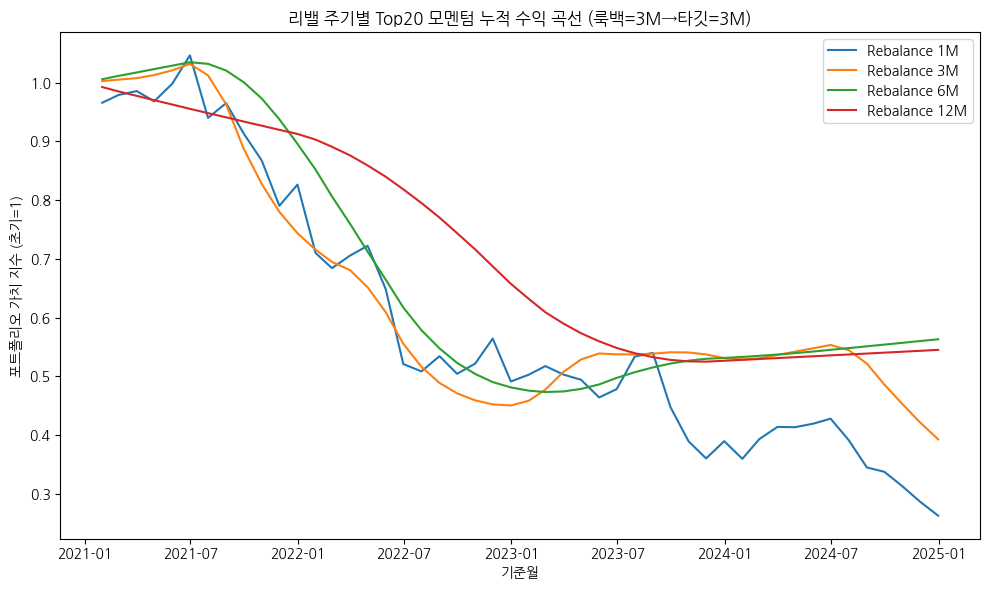

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 및 전처리
# ───────────────────────────────────────────────────────────────────
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)

# 1A) “기준월” 문자열이 "YYYY-MM" 또는 "YYYY-MM-01" 등의 형태로 되어 있다면,
#     아래처럼 to_datetime만 사용해도 무방합니다.
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)

# 1B) 필수 칼럼 확인
required = ['기준월', '종목코드',
            '1개월수익률','3개월수익률','6개월수익률','12개월수익률']
for col in required:
    if col not in df.columns:
        raise KeyError(f"필수 칼럼 '{col}'이 없습니다.")

# 1C) 종목 코드별로 “forward” 누적수익 컬럼 생성
#     - forward_ret_1m  = 다음 월 1개월 누적수익
#     - forward_ret_3m  = 다음 3개월 누적수익
#     - forward_ret_6m  = 다음 6개월 누적수익
#     - forward_ret_12m = 다음 12개월 누적수익
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

df['forward_ret_1m']  = df.groupby('종목코드')['1개월수익률'].shift(-1)
df['forward_ret_3m']  = df.groupby('종목코드')['3개월수익률'].shift(-3)
df['forward_ret_6m']  = df.groupby('종목코드')['6개월수익률'].shift(-6)
df['forward_ret_12m'] = df.groupby('종목코드')['12개월수익률'].shift(-12)

# ───────────────────────────────────────────────────────────────────
# 2) 백테스트 함수 정의
# ───────────────────────────────────────────────────────────────────
def backtest_topN(df, lookback_col, forward_col, rebalance_months, top_n=20):
    """
    df             : DataFrame, 반드시 ['기준월','종목코드', lookback_col, forward_col]이 존재해야 함
    lookback_col   : 예: '3개월수익률' (과거 3개월 누적 수익)
    forward_col    : 예: 'forward_ret_3m' (다음 3개월 누적 수익)
    rebalance_months: int, 리밸 주기 (1, 3, 6, 12 중 하나)
    top_n          : int, 매 리밸 주기마다 상위 N개 종목을 편입
    """
    # (A) 필수 칼럼 확인
    for c in ['기준월', '종목코드', lookback_col, forward_col]:
        if c not in df.columns:
            raise KeyError(f"'{c}' 칼럼이 없습니다.")
    df2 = df.copy()

    # (B) 월별로 Unique한 기준월 추출 (정렬된 상태)
    months = df2['기준월'].drop_duplicates().sort_values().to_list()
    # 결과를 담을 시리즈: index=기준월, value=해당 월 상위 N 종목의 평균 forward 수익
    portf_ret = pd.Series(index=months, dtype=float)

    # (C) 월별 반복하며 리밸 진행
    for idx, current_month in enumerate(months):
        if idx % rebalance_months == 0:
            subset = df2[df2['기준월'] == current_month].dropna(subset=[lookback_col, forward_col])
            if subset.empty:
                portf_ret[current_month] = np.nan
                continue
            topN = subset.nlargest(top_n, lookback_col)
            avg_forward = topN[forward_col].mean()
            portf_ret[current_month] = avg_forward
        else:
            portf_ret[current_month] = np.nan

    # (D) 리밸 간격 전체에 동일 수익을 월별로 분할
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months

    portf_ret_filled = portf_ret.fillna(method='ffill')
    all_months = portf_ret_filled.index.to_list()
    expanded_index = []
    expanded_returns = []

    for i, month in enumerate(all_months):
        ret = portf_ret_filled.iloc[i]
        monthly_r = split_return(ret, rebalance_months)
        for m in range(rebalance_months):
            if i + m >= len(all_months):
                break
            expanded_index.append(all_months[i + m])
            expanded_returns.append(monthly_r[m])

    monthly_series = pd.Series(data=expanded_returns, index=expanded_index).sort_index()
    monthly_series = monthly_series.groupby(monthly_series.index).mean()

    return monthly_series.dropna()

# ───────────────────────────────────────────────────────────────────
# 3) 성과 지표 계산 함수
# ───────────────────────────────────────────────────────────────────
def compute_performance_metrics(ret_series, freq=12, rf=0.0):
    """
    ret_series : pandas Series, index=월(datetime), value=월별 포트폴리오 수익 (예: 0.02=2%)
    freq       : 연환산 주기 (12=월별 데이터)
    rf         : 무위험이자율 (연 환산)
    """
    wealth_index = (1 + ret_series).cumprod()
    cum_return = wealth_index.iloc[-1] - 1

    n_months = len(ret_series)
    n_years = n_months / freq
    cagr = (wealth_index.iloc[-1] ** (1 / n_years) - 1) if n_years > 0 else np.nan

    excess = ret_series - (rf / freq)
    avg_excess = excess.mean() * freq
    std_excess = excess.std() * np.sqrt(freq)
    sharpe = avg_excess / std_excess if std_excess != 0 else np.nan

    running_max = wealth_index.cummax()
    drawdown = (wealth_index / running_max) - 1
    mdd = drawdown.min()

    return {
        'Cumulative': cum_return,
        'CAGR':       cagr,
        'Sharpe':     sharpe,
        'MDD':        mdd
    }

# ───────────────────────────────────────────────────────────────────
# 4) 전체 실험: 리밸 주기별(1M, 3M, 6M, 12M) 재백테스트
# ───────────────────────────────────────────────────────────────────
results = []
rebalance_list = [1, 3, 6, 12]

for rb in rebalance_list:
    lookback_col = '3개월수익률'
    forward_col = f'forward_ret_{rb}m' if rb != 1 else 'forward_ret_1m'

    portf_ts = backtest_topN(
        df=df,
        lookback_col=lookback_col,
        forward_col=forward_col,
        rebalance_months=rb,
        top_n=50
    )

    perf = compute_performance_metrics(portf_ts, freq=12, rf=0.0)
    results.append({
        'Rebalance (M)': rb,
        'Cumulative':    perf['Cumulative'],
        'CAGR':          perf['CAGR'],
        'Sharpe':        perf['Sharpe'],
        'MDD':           perf['MDD']
    })

res_df = pd.DataFrame(results).set_index('Rebalance (M)')
print("=== 리밸 주기별 Top20 포트폴리오 성과 (룩백=3M → 타깃=3M) ===")
print(res_df)

# ───────────────────────────────────────────────────────────────────
# 5) 누적 수익 곡선 시각화
# ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
for rb in rebalance_list:
    lookback_col = '3개월수익률'
    forward_col = f'forward_ret_{rb}m' if rb != 1 else 'forward_ret_1m'
    ts = backtest_topN(df, lookback_col, forward_col, rb, top_n=50)
    wealth = (1 + ts).cumprod()
    plt.plot(wealth.index, wealth.values, label=f'Rebalance {rb}M')

plt.title("리밸 주기별 Top20 모멘텀 누적 수익 곡선 (룩백=3M→타깃=3M)")
plt.xlabel("기준월")
plt.ylabel("포트폴리오 가치 지수 (초기=1)")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import numpy as np

# 1) 데이터 로드 및 “룩백·타깃” 생성
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

# 기존처럼 forward_ret_3m 생성
df['forward_ret_3m'] = df.groupby('종목코드')['3개월수익률'].shift(-3)

# 2) “검증용 forward”를 따로 만들어서 비교
df['check_forward_3m'] = df.groupby('종목코드')['3개월수익률'].shift(-3)

# 3) 종목 하나(예: 첫 번째 종목코드) 샘플로 눈으로 확인
sample_code = df['종목코드'].unique()[0]
sample_df = df[df['종목코드'] == sample_code][
    ['기준월', '3개월수익률', 'check_forward_3m', 'forward_ret_3m']
]
print("==== 종목코드:", sample_code, "의 일부 데이터 (3M shift 비교) ====")
print(sample_df.head(10))

# 4) 전체 종목에 대해 완전 일치 여부 검증
df['match_3m'] = (df['check_forward_3m'] == df['forward_ret_3m']) | (
    df['check_forward_3m'].isna() & df['forward_ret_3m'].isna()
)
if df['match_3m'].all():
    print("\n✅ 모든 forward_ret_3m이 shift(-3)와 완벽히 일치합니다.")
else:
    bad = df[~df['match_3m']]
    print("\n⚠️ 일부 불일치 (shift(-3) 오류) 건수:", len(bad))
    print(bad.head())

# 5) “첫 리밸 시점”이 잘 찍히는지 샘플 출력
def print_portfolio_sample(df, lookback_col, forward_col, rebalance_months, top_n=5):
    df2 = df.sort_values(['종목코드','기준월']).copy()
    months = df2['기준월'].drop_duplicates().sort_values().to_list()
    portf_ret = pd.Series(index=months, dtype=float)

    # (A) 리밸 시점마다 TopN 평균 forward 수익 산출
    for idx, current_month in enumerate(months):
        if idx % rebalance_months == 0:
            subset = df2[df2['기준월']==current_month].dropna(subset=[lookback_col, forward_col])
            topN   = subset.nlargest(top_n, lookback_col)
            portf_ret[current_month] = topN[forward_col].mean()
        else:
            portf_ret[current_month] = np.nan

    # (B) split_return: 리밸 평균 forward를 n개월 동안 균등 분할
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months

    portf_ret_filled = portf_ret.fillna(method='ffill')
    all_months = portf_ret_filled.index.to_list()

    print("\n--- 첫 리밸 시점 및 이후 분할 리턴 확인 (Top5 예시) ---")
    first_rb = next(m for i, m in enumerate(all_months) if not np.isnan(portf_ret[m]))
    print("첫 리밸 시점:", first_rb)
    print("  1) 첫 리밸 시점 평균 forward:", portf_ret[first_rb])
    print("  2) split_return 결과:", split_return(portf_ret[first_rb], rebalance_months))

    # (C) 실제 backtest_topN과 동일한 로직으로 만들어진 월별 시계열을 일부 출력
    expanded_index = []
    expanded_returns = []
    for i, m in enumerate(all_months):
        r = portf_ret_filled.iloc[i]
        monthly_r = split_return(r, rebalance_months)
        for k in range(rebalance_months):
            if i + k >= len(all_months):
                break
            expanded_index.append(all_months[i + k])
            expanded_returns.append(monthly_r[k])
    monthly_series = pd.Series(data=expanded_returns, index=expanded_index).groupby(level=0).mean()
    print("  3) 실제 월별 포트폴리오 수익 (처음 몇 달):")
    print(monthly_series.loc[first_rb : first_rb + pd.DateOffset(months=rebalance_months+1)])

# 룩백=3개월수익률, 타깃=forward_ret_3m, 리밸=3개월, Top5 예시
print_portfolio_sample(df, lookback_col='3개월수익률', forward_col='forward_ret_3m', rebalance_months=3, top_n=5)

==== 종목코드: 20 의 일부 데이터 (3M shift 비교) ====
         기준월    3개월수익률  check_forward_3m  forward_ret_3m
0 2021-01-31 -0.100686         -0.284987       -0.284987
1 2021-02-28 -0.140496         -0.016026       -0.016026
2 2021-03-31 -0.277778          0.020979        0.020979
3 2021-04-30 -0.284987          0.124555        0.124555
4 2021-05-31 -0.016026         -0.045603       -0.045603
5 2021-06-30  0.020979          0.010274        0.010274
6 2021-07-31  0.124555          0.240506        0.240506
7 2021-08-31 -0.045603          0.071672        0.071672
8 2021-09-30  0.010274          0.010169        0.010169
9 2021-10-31  0.240506         -0.255102       -0.255102

✅ 모든 forward_ret_3m이 shift(-3)와 완벽히 일치합니다.

--- 첫 리밸 시점 및 이후 분할 리턴 확인 (Top5 예시) ---
첫 리밸 시점: 2021-01-31 00:00:00
  1) 첫 리밸 시점 평균 forward: 0.21733907060000002
  2) split_return 결과: [np.float64(0.0677523116151868), np.float64(0.0677523116151868), np.float64(0.0677523116151868)]
  3) 실제 월별 포트폴리오 수익 (처음 몇 달):
2021-01-31    0.067752


=== 산업더미 잔차(ret_3m_resid) 룩백 결과 ===
               Cumulative      CAGR    Sharpe       MDD
Rebalance (M)                                          
1               -0.978718 -0.618052 -2.213478 -0.978600
3               -0.668598 -0.241267 -2.146085 -0.667524
6               -0.284738 -0.080363 -1.381700 -0.315519
12               0.213323  0.049528  2.241330 -0.023719


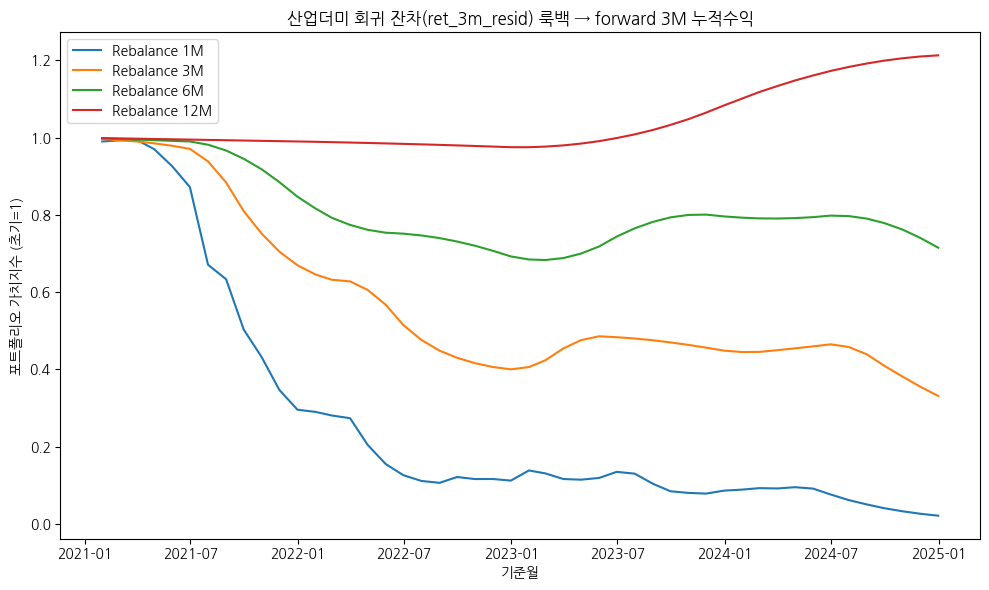

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1) 데이터 로드 및 전처리 (이전과 동일)
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)
df = df.sort_values(['종목코드','기준월']).reset_index(drop=True)
df['forward_ret_3m'] = df.groupby('종목코드')['3개월수익률'].shift(-3)

# 2) “산업더미 회귀 → 잔차(residual)” 생성 함수import pandas as pd

def industry_neutral_residual(df):
    """
    df: 원본 DataFrame. 반드시 아래 칼럼들을 포함해야 함:
        ['기준월', '종목코드', '산업군', '3개월수익률']

    리턴: 원본 df에 'ret_3m_resid' 칼럼을 추가한 DataFrame
        - 'ret_3m_resid'는 “월별 3개월 수익률”에서 “산업효과”를 회귀로 제거한 잔차(residual)
    """
    out = []
    # 1) '기준월' 별로 그룹을 묶어서 회귀 수행
    for month, sub in df.groupby('기준월'):
        sub = sub.copy()

        # (A) 3개월수익률 → 숫자형으로 강제 변환 후, 결측치(NaN)가 있으면 해당 행(drop) 처리
        sub['3개월수익률'] = pd.to_numeric(sub['3개월수익률'], errors='coerce')
        sub = sub.dropna(subset=['3개월수익률', '산업군']).reset_index(drop=True)

        if sub.shape[0] < 2:
            # 회귀를 돌릴 수 없을 정도로 데이터가 적으면, residual을 NaN으로 채워 주고 넘어감
            sub['ret_3m_resid'] = np.nan
            out.append(sub)
            continue

        # (B) 산업군 더미 생성 (drop_first=False 로 모든 카테고리를 살리거나,
        #     drop_first=True로 한 개 industrial category를 기준으로 삼을 수 있음)
        dummies = pd.get_dummies(sub['산업군'], drop_first=False)

        # (C) 설명변수 X와 종속변수 y 정의
        #     - X: ['const'] + 산업군 더미
        #     - y: sub['3개월수익률']
        X = sm.add_constant(dummies.astype(float))       # 반드시 float 타입으로 변환
        y = sub['3개월수익률']                            # 이미 숫자형

        # (D) OLS 회귀 실행, 잔차(resid)를 저장
        model = sm.OLS(y, X).fit()
        sub['ret_3m_resid'] = model.resid.values

        out.append(sub)

    return pd.concat(out, ignore_index=True)

# 3) ret_3m_resid 생성
df = industry_neutral_residual(df)

# 4) backtest 함수(전과 동일)를 가져와서, lookback_col='ret_3m_resid' 로 넘겨준다
def backtest_topN(df, lookback_col, forward_col, rebalance_months, top_n=20):
    # (A) 필수 칼럼 확인
    for c in ['기준월', '종목코드', lookback_col, forward_col]:
        if c not in df.columns:
            raise KeyError(f"'{c}' 칼럼이 없습니다.")
    df2 = df.copy()

    # (B) 월별 Unique 기준월
    months = df2['기준월'].drop_duplicates().sort_values().tolist()
    portf_ret = pd.Series(index=months, dtype=float)

    # (C) 리밸 반복
    for idx, current_month in enumerate(months):
        if idx % rebalance_months == 0:
            subset = df2[df2['기준월']==current_month].dropna(subset=[lookback_col, forward_col])
            if subset.empty:
                portf_ret[current_month] = np.nan
                continue
            topN = subset.nlargest(top_n, lookback_col)
            portf_ret[current_month] = topN[forward_col].mean()
        else:
            portf_ret[current_month] = np.nan

    # (D) 월별 분할 (split_return 동일)
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months

    portf_ret_filled = portf_ret.fillna(method='ffill')
    all_months = portf_ret_filled.index.to_list()
    expanded_index = []
    expanded_returns = []

    for i, m in enumerate(all_months):
        r = portf_ret_filled.iloc[i]
        monthly_r = split_return(r, rebalance_months)
        for k in range(rebalance_months):
            if i + k >= len(all_months):
                break
            expanded_index.append(all_months[i + k])
            expanded_returns.append(monthly_r[k])

    monthly_series = pd.Series(data=expanded_returns, index=expanded_index).sort_index()
    monthly_series = monthly_series.groupby(level=0).mean()
    return monthly_series.dropna()

# 5) “산업더미 잔차(ret_3m_resid) 룩백 → forward_ret_3m” 백테스트
results_resid = []
rebalance_list = [1, 3, 6, 12]

for rb in rebalance_list:
    lookback_col = 'ret_3m_resid'
    forward_col  = 'forward_ret_3m'
    portf_ts = backtest_topN(df, lookback_col, forward_col, rebalance_months=rb, top_n=50)

    perf = compute_performance_metrics(portf_ts, freq=12, rf=0.0)
    results_resid.append({
        'Rebalance (M)': rb,
        'Cumulative':    perf['Cumulative'],
        'CAGR':          perf['CAGR'],
        'Sharpe':        perf['Sharpe'],
        'MDD':           perf['MDD']
    })

res_resid_df = pd.DataFrame(results_resid).set_index('Rebalance (M)')
print("=== 산업더미 잔차(ret_3m_resid) 룩백 결과 ===")
print(res_resid_df)

# 6) 누적 수익 곡선 시각화 예시
plt.figure(figsize=(10, 6))
for rb in rebalance_list:
    ts = backtest_topN(df, lookback_col='ret_3m_resid', forward_col='forward_ret_3m', rebalance_months=rb, top_n=50)
    plt.plot((1 + ts).cumprod(), label=f'Rebalance {rb}M')
plt.title("산업더미 회귀 잔차(ret_3m_resid) 룩백 → forward 3M 누적수익")
plt.xlabel("기준월")
plt.ylabel("포트폴리오 가치지수 (초기=1)")
plt.legend()
plt.tight_layout()
plt.show()

=== 산업더미 잔차(ret_3m_resid) 룩백 → forward 3M 성과 비교 ===
               Cumulative      CAGR    Sharpe       MDD
Rebalance (M)                                          
1               -0.978718 -0.618052 -2.213478 -0.978600
3               -0.668598 -0.241267 -2.146085 -0.667524
6               -0.284738 -0.080363 -1.381700 -0.315519
12               0.213323  0.049528  2.241330 -0.023719


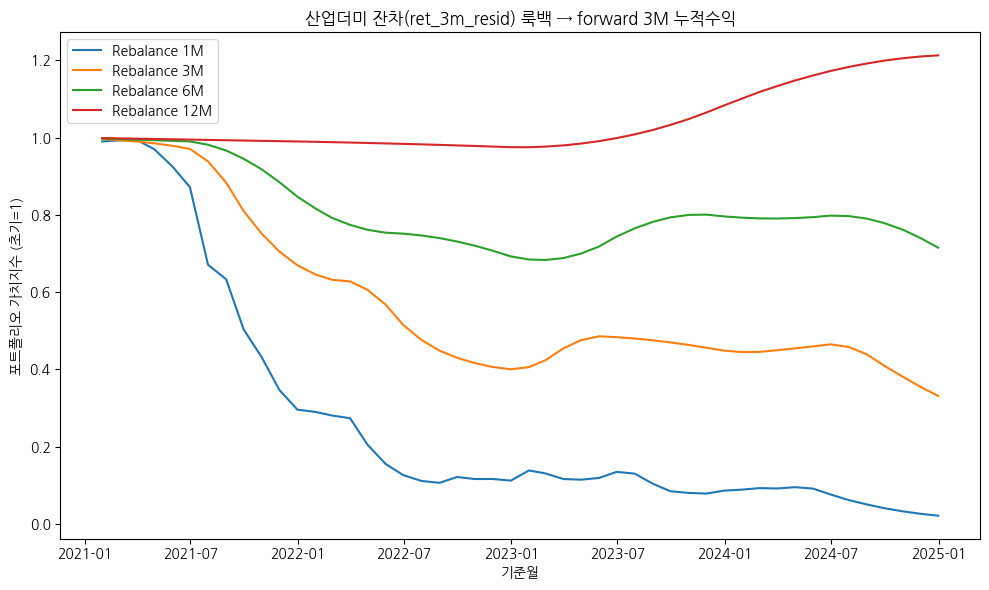

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 및 전처리
# ───────────────────────────────────────────────────────────────────
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)

# 1A) “기준월” 문자열 → datetime(월말)
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)

# 1B) 필수 칼럼 확인
required = ['기준월', '종목코드', '산업군',
            '1개월수익률','3개월수익률','6개월수익률','12개월수익률']
for col in required:
    if col not in df.columns:
        raise KeyError(f"필수 칼럼 '{col}'이 없습니다.")

# 1C) forward 누적수익 컬럼 생성 (shift 방식)
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)
df['forward_ret_1m']  = df.groupby('종목코드')['1개월수익률'].shift(-1)
df['forward_ret_3m']  = df.groupby('종목코드')['3개월수익률'].shift(-3)
df['forward_ret_6m']  = df.groupby('종목코드')['6개월수익률'].shift(-6)
df['forward_ret_12m'] = df.groupby('종목코드')['12개월수익률'].shift(-12)


# ───────────────────────────────────────────────────────────────────
# 2) 산업중립 잔차 생성 함수 (수정 버전)
# ───────────────────────────────────────────────────────────────────
def industry_neutral_residual(df):
    out = []
    for month, sub in df.groupby('기준월'):
        sub = sub.copy()
        # (A) 3개월수익률 → float 변환, 결측 행 삭제
        sub['3개월수익률'] = pd.to_numeric(sub['3개월수익률'], errors='coerce')
        sub = sub.dropna(subset=['3개월수익률','산업군']).reset_index(drop=True)

        if sub.shape[0] < 2:
            sub['ret_3m_resid'] = np.nan
            out.append(sub)
            continue

        # (B) 산업군 더미 생성 (object→float로 캐스팅)
        dummies = pd.get_dummies(sub['산업군'], drop_first=False).astype(float)

        # (C) OLS 회귀: y ~ const + 산업더미
        X = sm.add_constant(dummies)
        y = sub['3개월수익률']
        model = sm.OLS(y, X).fit()

        # (D) 잔차 저장
        sub['ret_3m_resid'] = model.resid.values
        out.append(sub)

    return pd.concat(out, ignore_index=True)

# (실제로는 3~4분 정도 시간이 걸립니다. 데이터 크기에 따라 더 오래 걸릴 수 있음)
df = industry_neutral_residual(df)


# ───────────────────────────────────────────────────────────────────
# 3) 백테스트 & 성과 계산 함수 (이전과 동일)
# ───────────────────────────────────────────────────────────────────
def backtest_topN(df, lookback_col, forward_col, rebalance_months, top_n=20):
    for c in ['기준월', '종목코드', lookback_col, forward_col]:
        if c not in df.columns:
            raise KeyError(f"'{c}' 칼럼이 없습니다.")
    df2 = df.copy()
    months = df2['기준월'].drop_duplicates().sort_values().tolist()
    portf_ret = pd.Series(index=months, dtype=float)

    for idx, current_month in enumerate(months):
        if idx % rebalance_months == 0:
            subset = df2[df2['기준월']==current_month].dropna(subset=[lookback_col, forward_col])
            if subset.empty:
                portf_ret[current_month] = np.nan
                continue
            topN = subset.nlargest(top_n, lookback_col)
            portf_ret[current_month] = topN[forward_col].mean()
        else:
            portf_ret[current_month] = np.nan

    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months

    portf_ret_filled = portf_ret.fillna(method='ffill')
    all_months = portf_ret_filled.index.to_list()
    expanded_index = []
    expanded_returns = []

    for i, m in enumerate(all_months):
        r = portf_ret_filled.iloc[i]
        monthly_r = split_return(r, rebalance_months)
        for k in range(rebalance_months):
            if i + k >= len(all_months):
                break
            expanded_index.append(all_months[i + k])
            expanded_returns.append(monthly_r[k])

    monthly_series = pd.Series(data=expanded_returns, index=expanded_index).sort_index()
    monthly_series = monthly_series.groupby(level=0).mean()
    return monthly_series.dropna()

def compute_performance_metrics(ret_series, freq=12, rf=0.0):
    wealth_index = (1 + ret_series).cumprod()
    cum_return = wealth_index.iloc[-1] - 1

    n_months = len(ret_series)
    n_years = n_months / freq
    cagr = (wealth_index.iloc[-1] ** (1 / n_years) - 1) if n_years > 0 else np.nan

    excess = ret_series - (rf / freq)
    avg_excess = excess.mean() * freq
    std_excess = excess.std() * np.sqrt(freq)
    sharpe = avg_excess / std_excess if std_excess != 0 else np.nan

    running_max = wealth_index.cummax()
    drawdown = (wealth_index / running_max) - 1
    mdd = drawdown.min()

    return {
        'Cumulative': cum_return,
        'CAGR':       cagr,
        'Sharpe':     sharpe,
        'MDD':        mdd
    }


# ───────────────────────────────────────────────────────────────────
# 4) 실제 백테스트: “산업더미 잔차(ret_3m_resid) 룩백 → forward_ret_3m” 
#                   각 리밸 주기별로 Top50 성과 비교
# ───────────────────────────────────────────────────────────────────
results_resid = []
rebalance_list = [1, 3, 6, 12]

for rb in rebalance_list:
    lookback_col = 'ret_3m_resid'
    forward_col  = 'forward_ret_3m'
    portf_ts = backtest_topN(df, lookback_col, forward_col, rebalance_months=rb, top_n=50)
    perf = compute_performance_metrics(portf_ts, freq=12, rf=0.0)
    results_resid.append({
        'Rebalance (M)': rb,
        'Cumulative':    perf['Cumulative'],
        'CAGR':          perf['CAGR'],
        'Sharpe':        perf['Sharpe'],
        'MDD':           perf['MDD']
    })

res_resid_df = pd.DataFrame(results_resid).set_index('Rebalance (M)')
print("=== 산업더미 잔차(ret_3m_resid) 룩백 → forward 3M 성과 비교 ===")
print(res_resid_df)

# ───────────────────────────────────────────────────────────────────
# 5) 누적 수익 곡선 시각화 (옵션)
# ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
for rb in rebalance_list:
    ts = backtest_topN(df, lookback_col='ret_3m_resid', forward_col='forward_ret_3m', rebalance_months=rb, top_n=50)
    plt.plot((1 + ts).cumprod(), label=f'Rebalance {rb}M')
plt.title("산업더미 잔차(ret_3m_resid) 룩백 → forward 3M 누적수익")
plt.xlabel("기준월")
plt.ylabel("포트폴리오 가치지수 (초기=1)")
plt.legend()
plt.tight_layout()
plt.show()

=== 16개 룩백×포워드 조합 상관 & 분위수별 요약 ===
lookback_ind         forward  pearson_corr pearson_pval  bottom_1q  top_5q  diff(5q−1q)
 12개월수익률_ind  forward_ret_3m       -0.0194      3.5e-07    -0.0031  0.0002       0.0033
 12개월수익률_ind  forward_ret_1m       -0.0244      5.6e-11     0.0090  0.0011      -0.0079
  3개월수익률_ind  forward_ret_3m       -0.0250      5.6e-11    -0.0026 -0.0016       0.0010
  3개월수익률_ind forward_ret_12m       -0.0260      1.0e-09    -0.0443 -0.0467      -0.0024
  1개월수익률_ind forward_ret_12m       -0.0325      2.4e-14    -0.0234 -0.0546      -0.0311
  1개월수익률_ind  forward_ret_3m       -0.0344      1.7e-19     0.0068 -0.0125      -0.0193
  3개월수익률_ind  forward_ret_1m       -0.0356      1.2e-21     0.0103 -0.0015      -0.0118
  6개월수익률_ind  forward_ret_1m       -0.0400      6.6e-27     0.0164  0.0004      -0.0160
  6개월수익률_ind forward_ret_12m       -0.0416      1.8e-22    -0.0246 -0.0595      -0.0349
  6개월수익률_ind  forward_ret_3m       -0.0429      2.0e-29     0.0200 -0.0022      -0.02

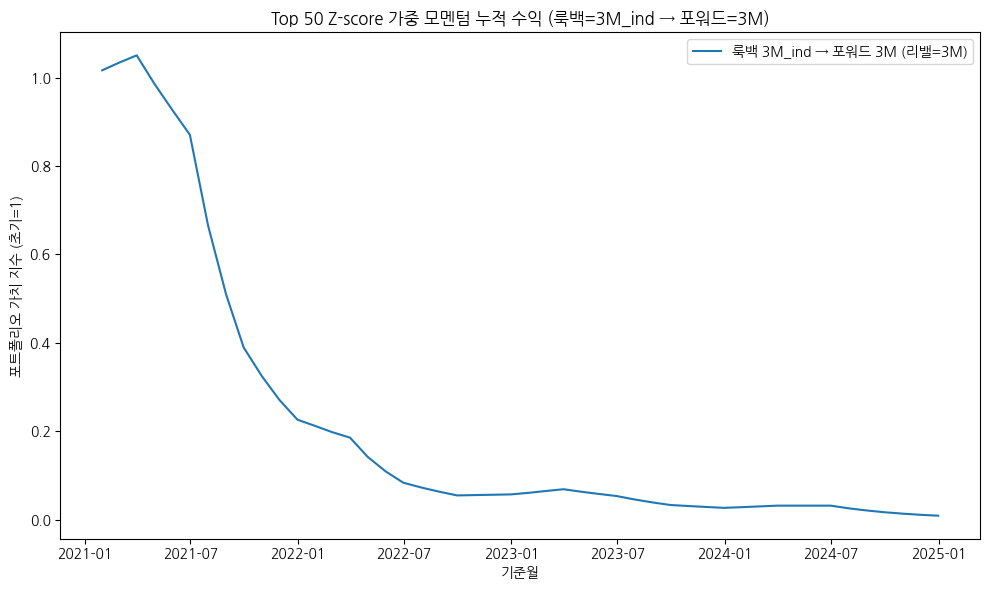


=== 모든 룩백×포워드 (리밸=3M) 백테스트 성과 요약 ===
   lookback         forward  Cumulative    CAGR  Sharpe     MDD
12개월수익률_ind  forward_ret_1m     -0.8793 -0.4106 -1.3988 -0.8667
 1개월수익률_ind  forward_ret_6m     -0.9932 -0.7132 -1.6061 -0.9939
 6개월수익률_ind  forward_ret_6m     -0.9979 -0.7863 -1.6689 -0.9980
 6개월수익률_ind  forward_ret_3m     -0.9865 -0.6592 -1.6773 -0.9859
 3개월수익률_ind  forward_ret_6m     -0.9969 -0.7646 -1.7223 -0.9970
 1개월수익률_ind  forward_ret_1m     -0.8049 -0.3354 -1.9356 -0.8307
 6개월수익률_ind  forward_ret_1m     -0.9022 -0.4408 -1.9685 -0.8985
12개월수익률_ind  forward_ret_6m     -0.9971 -0.7676 -2.0528 -0.9969
12개월수익률_ind  forward_ret_3m     -0.9914 -0.6957 -2.1038 -0.9900
 3개월수익률_ind  forward_ret_1m     -0.8987 -0.4359 -2.4094 -0.8949
 6개월수익률_ind forward_ret_12m     -0.9998 -0.8808 -2.4710 -0.9998
 1개월수익률_ind  forward_ret_3m     -0.9880 -0.6687 -3.0050 -0.9900
 3개월수익률_ind  forward_ret_3m     -0.9912 -0.6937 -3.1266 -0.9916
 3개월수익률_ind forward_ret_12m     -0.9999 -0.9147 -3.2309 -0.9999
 1

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────
# 1) 데이터 로드 & 전처리
# ──────────────────────────────────────────────────────────────
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)

# 1A) 기준월 → 월말로 맞추기
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)

# 1B) 필수 컬럼 체크
required_cols = [
    '기준월', '종목코드', '산업군',
    '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률'
]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"필수 컬럼 '{c}'이 없습니다.")

# 1C) 정렬
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

# 1D) “Forward” 누적수익 컬럼 생성 (shift)
df['forward_ret_1m']  = df.groupby('종목코드')['1개월수익률'].shift(-1)
df['forward_ret_3m']  = df.groupby('종목코드')['3개월수익률'].shift(-3)
df['forward_ret_6m']  = df.groupby('종목코드')['6개월수익률'].shift(-6)
df['forward_ret_12m'] = df.groupby('종목코드')['12개월수익률'].shift(-12)

# ──────────────────────────────────────────────────────────────
# 2) 산업중립 Z-score 계산 (룩백 컬럼)
# ──────────────────────────────────────────────────────────────
lookbacks = ['1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률']
for lb in lookbacks:
    col_ind = lb + '_ind'
    # 같은 산업군별로 평균 μ, 표준편차 σ 를 구해서 Z-score 계산
    df[col_ind] = df.groupby('산업군')[lb].transform(
        lambda x: (x - x.mean()) / (x.std(ddof=0) if x.std(ddof=0) != 0 else 1.0)
    )

# 결과적으로 df 에는 아래 네 개의 “산업중립 Z-score 룩백” 컬럼이 추가됨:
#   '1개월수익률_ind', '3개월수익률_ind', '6개월수익률_ind', '12개월수익률_ind'


# ──────────────────────────────────────────────────────────────
# 3) 룩백×포워드 16개 조합 동시 비교 (Pearson 상관 + 분위수별 평균)
# ──────────────────────────────────────────────────────────────
import itertools

lb_ind_cols = ['1개월수익률_ind', '3개월수익률_ind', '6개월수익률_ind', '12개월수익률_ind']
fw_cols     = ['forward_ret_1m',    'forward_ret_3m',    'forward_ret_6m',    'forward_ret_12m']

records = []
for lb_col, fw_col in itertools.product(lb_ind_cols, fw_cols):
    tmp = df[[lb_col, fw_col]].dropna()
    if len(tmp) < 50:
        # 데이터가 너무 적으면 스킵
        continue

    # 1) Pearson 상관계수 계산
    corr, pval = pearsonr(tmp[lb_col], tmp[fw_col])

    # 2) 룩백_ind 기준 5 분위수(qcut) → 하위 20% vs 상위 20% 평균 forward 수익
    tmp['quantile_5'] = pd.qcut(tmp[lb_col], 5, labels=False) + 1
    q1_mean = tmp[tmp['quantile_5'] == 1][fw_col].mean()
    q5_mean = tmp[tmp['quantile_5'] == 5][fw_col].mean()
    diff_q5_q1 = q5_mean - q1_mean

    records.append({
        'lookback_ind': lb_col,
        'forward':      fw_col,
        'pearson_corr': round(corr, 4),
        'pearson_pval': f"{pval:.1e}",
        'bottom_1q':    round(q1_mean, 4),
        'top_5q':       round(q5_mean, 4),
        'diff(5q−1q)':  round(diff_q5_q1, 4)
    })

summary_df = pd.DataFrame(records)
summary_df = summary_df.sort_values('pearson_corr', ascending=False).reset_index(drop=True)

print("=== 16개 룩백×포워드 조합 상관 & 분위수별 요약 ===")
print(summary_df.to_string(index=False))


# ──────────────────────────────────────────────────────────────
# 4) Top 50 Z-score 가중 백테스트 함수 정의 (룩백_ind → forward_xm)
# ──────────────────────────────────────────────────────────────
def backtest_weighted_top50(df, lookback_col, forward_col, rebalance_months=3):
    """
    df              : DataFrame, ['기준월','종목코드', lookback_col, forward_col]이 반드시 있어야 함
    lookback_col    : 예) '3개월수익률_ind'  (산업중립 Z-score)
    forward_col     : 예) 'forward_ret_3m'
    rebalance_months: int, 리밸 주기(1/3/6/12)

    - 매 리밸 시점에 룩백_col 기준 상위 50개 종목을 뽑아
      “룩백 Z-score”를 비중으로 사용해 Weighted Forward Return 을 계산.
    - 그 결과를 rebalance_months 개월 동안 균등하게 월로 나눠서 최종 월별 수익 시계열을 리턴.
    """
    # (A) 필수 칼럼 체크
    for c in ['기준월', '종목코드', lookback_col, forward_col]:
        if c not in df.columns:
            raise KeyError(f"'{c}' 컬럼이 없습니다.")

    # (B) 필요한 컬럼만 복사 & 정렬
    df2 = df[['기준월', '종목코드', lookback_col, forward_col]].copy()
    df2 = df2.sort_values(['기준월', lookback_col], ascending=[True, False]).reset_index(drop=True)

    # (C) 유니크한 월(리밸 시점) 리스트
    months = df2['기준월'].drop_duplicates().sort_values().to_list()

    # (D) 리밸 시점별 “Top50 가중 평균 Forward Return” 계산 → series 저장
    portf_rets_at_rebal = pd.Series(index=months, dtype=float)

    for idx, mon in enumerate(months):
        if idx % rebalance_months != 0:
            # 리밸이 아닌 달: NaN
            portf_rets_at_rebal[mon] = np.nan
            continue

        sub = df2[df2['기준월'] == mon].dropna(subset=[lookback_col, forward_col])
        if sub.empty:
            portf_rets_at_rebal[mon] = np.nan
            continue

        # (1) 룩백 Z-score가 음수인 값은 0으로 클리핑한 뒤
        sub['z_clip'] = sub[lookback_col].clip(lower=0.0)

        # (2) Top 50 추출
        df_top50 = sub.nlargest(50, 'z_clip')

        # (3) 가중치 계산: z_clip 합이 0이면 평등비중, 아니면 z_clip 비중
        total_z = df_top50['z_clip'].sum()
        if total_z == 0:
            w = np.repeat(1.0/len(df_top50), len(df_top50))
        else:
            w = df_top50['z_clip'] / total_z

        # (4) 해당 리밸 시점의 평균 Forward Return (Weighted)
        avg_fw = (df_top50[forward_col].values * w.values).sum()
        portf_rets_at_rebal[mon] = avg_fw

    # (E) “리밸 시점별 리턴(portf_rets_at_rebal)”을 월화(月化)로 분할
    def split_return(x, n_periods):
        if pd.isna(x):
            return [np.nan]*n_periods
        # (1 + x)^(1/n) - 1 형태로 월화
        mr = (1 + x)**(1.0 / n_periods) - 1
        return [mr]*n_periods

    filled = portf_rets_at_rebal.fillna(method='ffill')
    all_months = filled.index.to_list()

    expanded_idx = []
    expanded_vals = []
    for i, mon in enumerate(all_months):
        val = filled.iloc[i]
        for _ in range(rebalance_months):
            expanded_idx.append(mon)
            expanded_vals.append(val)

    monthly_ret = pd.Series(data=expanded_vals, index=expanded_idx).sort_index()
    # 동일 월에 여러 개가 들어갈 수 있으므로, 평균으로 통합
    monthly_ret = monthly_ret.groupby(monthly_ret.index).mean()

    return monthly_ret.dropna()


# ──────────────────────────────────────────────────────────────
# 5) 성과 지표 계산 함수 (CAGR, Sharpe, MDD)
# ──────────────────────────────────────────────────────────────
def compute_performance_metrics(ret_series, freq=12, rf=0.0):
    """
    ret_series : pandas.Series (index=월(datetime), value=월별 수익률)
    freq       : 연환산 주기(월별 데이터면 12)
    rf         : 연환산 무위험 이자율(예: 0.0)
    """
    # (A) 누적지수(Wealth Index)
    wi = (1 + ret_series).cumprod()
    cum_return = wi.iloc[-1] - 1

    # (B) CAGR
    n_months = len(ret_series)
    n_years  = n_months / freq
    cagr = (wi.iloc[-1] ** (1.0 / n_years) - 1.0) if n_years > 0 else np.nan

    # (C) Sharpe (연환산)
    excess = ret_series - (rf / freq)
    ann_excess_avg = excess.mean() * freq
    ann_excess_std = excess.std() * np.sqrt(freq)
    sharpe = ann_excess_avg / ann_excess_std if ann_excess_std != 0 else np.nan

    # (D) MDD (Max Drawdown)
    running_max = wi.cummax()
    drawdown   = (wi / running_max) - 1
    mdd = drawdown.min()

    return {
        'Cumulative': round(cum_return, 4),
        'CAGR':       round(cagr, 4),
        'Sharpe':     round(sharpe, 4),
        'MDD':        round(mdd, 4)
    }


# ──────────────────────────────────────────────────────────────
# 6) 예시: 룩백=3개월수익률_ind → 포워드=forward_ret_3m (리밸=3M)
# ──────────────────────────────────────────────────────────────
example_lb = '3개월수익률_ind'
example_fw = 'forward_ret_3m'

monthly_ts_3m = backtest_weighted_top50(
    df,
    lookback_col=example_lb,
    forward_col=example_fw,
    rebalance_months=3
)

perf_3m = compute_performance_metrics(monthly_ts_3m, freq=12, rf=0.0)
print("\n=== [예시] 룩백=3M_ind → 포워드=3M (Top50 Z-score 가중) ===")
print(perf_3m)

plt.figure(figsize=(10, 6))
wealth_3m = (1 + monthly_ts_3m).cumprod()
plt.plot(wealth_3m.index, wealth_3m.values, label='룩백 3M_ind → 포워드 3M (리밸=3M)')
plt.title("Top 50 Z-score 가중 모멘텀 누적 수익 (룩백=3M_ind → 포워드=3M)")
plt.xlabel("기준월")
plt.ylabel("포트폴리오 가치 지수 (초기=1)")
plt.legend()
plt.tight_layout()
plt.show()


# ──────────────────────────────────────────────────────────────
# 7) (추가) 모든 룩백_ind×포워드 조합에 대하여
#     “리밸=3M” 고정 → 백테스트 + 성과지표 요약
# ──────────────────────────────────────────────────────────────
results_bt = []
for lb in lb_ind_cols:
    for fw in fw_cols:
        ts_bt = backtest_weighted_top50(
            df,
            lookback_col=lb,
            forward_col=fw,
            rebalance_months=3
        )
        perf = compute_performance_metrics(ts_bt, freq=12, rf=0.0)
        results_bt.append({
            'lookback':    lb,
            'forward':     fw,
            'Cumulative':  perf['Cumulative'],
            'CAGR':        perf['CAGR'],
            'Sharpe':      perf['Sharpe'],
            'MDD':         perf['MDD']
        })

bt_df = pd.DataFrame(results_bt)
print("\n=== 모든 룩백×포워드 (리밸=3M) 백테스트 성과 요약 ===")
print(bt_df.sort_values(['Sharpe'], ascending=False).to_string(index=False))

=== 역모멘텀(룩백=3M→포워드=3M, 리밸=3M) 성과 ===
{'Cumulative': np.float64(1.0248), 'CAGR': np.float64(0.1929), 'Sharpe': np.float64(1.9133), 'MDD': np.float64(-0.1094)}


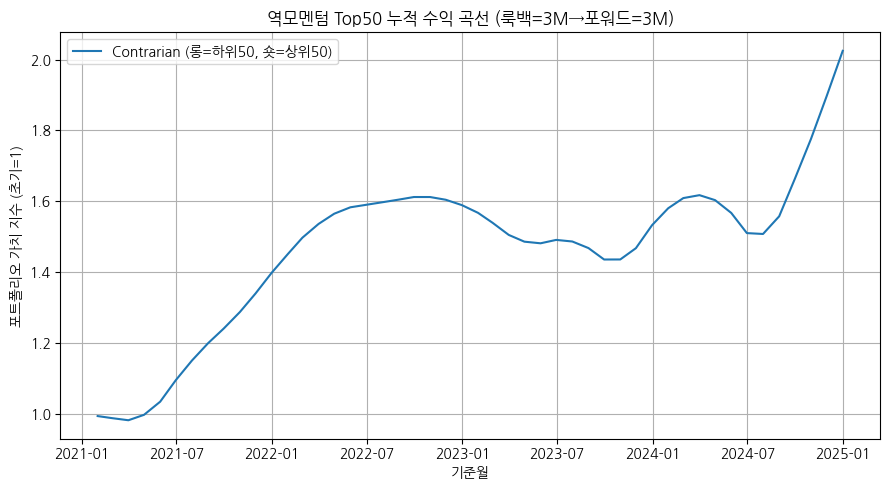

In [55]:
def backtest_contrarian_top50(df, lookback_col, forward_col, rebalance_months):
    """
    역모멘텀 (Contrarian) 백테스트
    - 매 리밸 주기(예: 3M)마다, 
      · 과거 lookback_col 상위 50 종목 → SHORT (숏)
      · 과거 lookback_col 하위 50 종목 → LONG  (롱)
    - 각각의 forward_col 수익률(누적)을 평균내어 ‘롱 − 숏’ 형태로 월별 리턴 생성
    - 이후 리밸 간격을 rebalance_months로 분할하여 월별 리턴을 만듦
    """
    # ─ (A) 컬럼 확인 ─
    for col in ['기준월','종목코드', lookback_col, forward_col]:
        if col not in df.columns:
            raise KeyError(f"칼럼 '{col}'이 없습니다.")

    df2 = df.copy()
    months = df2['기준월'].drop_duplicates().sort_values().to_list()
    portf_ret = pd.Series(index=months, dtype=float)

    # ─ (B) 매 리밸 시점마다 상/하위 50 종목 뽑고, 롱−숏 차이를 포트폴리오 수익으로 지정 ─
    for idx, mon in enumerate(months):
        if idx % rebalance_months == 0:
            sub = df2[df2['기준월'] == mon].dropna(subset=[lookback_col, forward_col])
            if sub.shape[0] < 50:
                # 종목이 50개 미만이면 None 처리
                portf_ret[mon] = np.nan
                continue

            # (1) 과거 모멘텀 상위 50개 → ‘숏’ 
            shorts = sub.nlargest(50, lookback_col)
            # (2) 과거 모멘텀 하위 50개 → ‘롱’
            longs  = sub.nsmallest(50, lookback_col)

            # 각 그룹의 평균 forward 수익
            avg_short = shorts[forward_col].mean()
            avg_long  = longs[forward_col].mean()

            # “롱 − 숏” 형태가 순수하게 역모멘텀 알파를 나타냄
            portf_ret[mon] = (avg_long - avg_short)
        else:
            portf_ret[mon] = np.nan

    # ─ (C) 분할 리턴 로직: 리밸 구간(rebalance_months)마다 동일 CAGR로 분할 ─
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan]*months
        # “(1 + (롱 − 숏))**(1/rebalance_months) − 1”로 매월 수익 환산
        return [((1 + x) ** (1 / months) - 1)] * months

    portf_ffill = portf_ret.fillna(method='ffill')
    all_months  = portf_ffill.index.to_list()
    expanded_idx = []
    expanded_ret = []

    for i, mon in enumerate(all_months):
        val = portf_ffill.iloc[i]
        m_ret = split_return(val, rebalance_months)
        for m in range(rebalance_months):
            if i + m >= len(all_months):
                break
            expanded_idx.append(all_months[i + m])
            expanded_ret.append(m_ret[m])

    monthly_series = pd.Series(data=expanded_ret, index=expanded_idx).sort_index()
    monthly_series = monthly_series.groupby(monthly_series.index).mean()
    return monthly_series.dropna()


# ───────────────────────────────────────────────────────────────────
# 사용 예시: 룩백=3개월수익률, forward=3개월 (rebalance=3M)
# ───────────────────────────────────────────────────────────────────
contra_ts = backtest_contrarian_top50(
    df=df, 
    lookback_col='3개월수익률', 
    forward_col='forward_ret_3m', 
    rebalance_months=3
)

# 역모멘텀 전략 성과 지표 계산
perf_contra = compute_performance_metrics(contra_ts, freq=12, rf=0.0)
print("=== 역모멘텀(룩백=3M→포워드=3M, 리밸=3M) 성과 ===")
print(perf_contra)

# 역모멘텀 누적수익 곡선
plt.figure(figsize=(9,5))
plt.plot((1+contra_ts).cumprod().index, (1+contra_ts).cumprod().values, label="Contrarian (롱=하위50, 숏=상위50)")
plt.title("역모멘텀 Top50 누적 수익 곡선 (룩백=3M→포워드=3M)")
plt.xlabel("기준월")
plt.ylabel("포트폴리오 가치 지수 (초기=1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def compute_industry_neutral_residuals(
    df: pd.DataFrame,
    lookback_col: str = '3개월수익률',
    industry_col: str = '산업군'
) -> pd.DataFrame:
    """
    ────────────────────────────────────────────────────────────────────
    목적:
      - 매월(月) 기준으로, ‘lookback_col’(예: '3개월수익률')을
        'industry_col'(예: '산업군')의 더미(dummy)로 회귀(OLS)하여,
        각 종목의 “잔차(residual)”를 새로운 컬럼으로 추가합니다.
      - 이렇게 계산된 잔차는 “산업중립 모멘텀 점수”로 사용할 수 있습니다.

    입력:
      df            : 원본 DataFrame. 반드시 다음 컬럼을 포함해야 함
                      ['기준월', '종목코드', industry_col, lookback_col]
      lookback_col  : str, 예: '3개월수익률' (월별 과거 누적 수익률)
      industry_col  : str, 예: '산업군'         (범주형: 각 종목이 속한 산업군)

    반환:
      df_out        : 원본 df에 "{lookback_col}_resid" 컬럼이 추가된 DataFrame
                      (예: '3개월수익률_resid' 컬럼이 생성됨)

    주의사항:
      1) df['기준월']은 반드시 pandas datetime 형식이어야 함
      2) industry_col(예: '산업군')에 NaN 값이 있다면 dropna 처리할 것
      3) lookback_col에도 NaN이 있으면 해당 월 회귀에서 제외됨
    ────────────────────────────────────────────────────────────────────
    """
    # 1) 필수 컬럼 확인
    for col in ['기준월', industry_col, lookback_col]:
        if col not in df.columns:
            raise KeyError(f"compute_industry_neutral_residuals: 필수 컬럼 '{col}'이 없습니다.")
    
    # 2) 계산 결과를 저장할 리스트
    out_list = []
    
    # 3) 입력 df 를 복사한 뒤, '기준월'을 datetime 으로 확실히 맞추고 정렬
    df_sorted = df.copy()
    df_sorted['기준월'] = pd.to_datetime(df_sorted['기준월'], errors='raise')
    df_sorted = df_sorted.sort_values(['기준월', '종목코드']).reset_index(drop=True)
    
    # 4) 모든 고유(유니크) 월(month) 리스트 생성
    months = sorted(df_sorted['기준월'].drop_duplicates().tolist())
    
    # 5) 각 월별로 회귀 수행
    for mon in months:
        # (A) 해당 월에 속한 모든 종목만 추출
        sub = df_sorted[df_sorted['기준월'] == mon].copy()
        
        # (B) 룩백 값(lookback_col)에 NaN 이 있는 행은 제거
        sub = sub[~sub[lookback_col].isna()].copy()
        
        if sub.empty:
            # 해당 월 회귀를 수행할 데이터가 없으므로 NaN 잔차만 채워 넣음
            temp = df_sorted[df_sorted['기준월'] == mon].copy()
            temp[f"{lookback_col}_resid"] = np.nan
            out_list.append(temp)
            continue
        
        # (C) 산업군 컬럼을 one-hot 더미(dummy)로 변환
        #     예: '산업군' 카테고리가 ['전자','금융','제약',...] 라면
        #         get_dummies 로 각 카테고리별 컬럼(0/1)이 생성됨
        dummies = pd.get_dummies(sub[industry_col], prefix="ind")
        
        # (D) X, y 준비
        #     - X: 상수항(constant) + 산업 더미(dummy들), 모두 float 타입이어야 함
        #     - y: lookback_col 값 (float)
        X = sm.add_constant(dummies.astype(float))          # DataFrame → numpy array 로 넘겨야 함
        y = sub[lookback_col].astype(float).values           # (n_obs, ) 형태의 1차원 배열
        
        # (E) OLS 회귀 실행: y ~ const + 산업더미(dummy들)
        model = sm.OLS(y, X.values).fit()
        
        # (F) 회귀 잔차(residual)만 sub 에 추가
        sub[f"{lookback_col}_resid"] = model.resid
        
        # (G) 월별 계산이 끝난 sub DataFrame 을 out_list 에 쌓아 둠
        out_list.append(sub)
    
    # 6) 모든 월의 sub 를 합쳐서 최종 DataFrame 을 반환
    df_out = pd.concat(out_list, ignore_index=True)
    
    # 7) 원본 df_sorted 에 없었던 컬럼(예: forward 컬럼 등)이 필요하다면 merge 로 붙이는 로직을 추가 가능
    #    예:
    #    df_extra = df_sorted[['기준월','종목코드','forward_ret_3m','forward_ret_6m',...]]
    #    df_out = df_out.merge(df_extra, on=['기준월','종목코드'], how='left')
    
    return df_out


# ───────────────────────────────────────────────────────────────────
# (함수 사용 예시)
# ───────────────────────────────────────────────────────────────────

# 1) 원본 CSV 로드 & 전처리 (예시)
csv_path = "/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv"
df = pd.read_csv(csv_path, encoding='utf-8')

# 2) “기준월”을 datetime + 월말로 변환
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)

# 3) 필수 칼럼 유무 체크
must_cols = [
    '기준월', '종목코드', '산업군',
    '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률'
]
for c in must_cols:
    if c not in df.columns:
        raise KeyError(f"필수 컬럼 '{c}'이 없습니다.")

# 4) Forward 컬럼(shift) 생성 (예시: 3개월 → forward_ret_3m)
df = df.sort_values(['종목코드','기준월']).reset_index(drop=True)
df['forward_ret_1m']  = df.groupby('종목코드')['1개월수익률'].shift(-1)
df['forward_ret_3m']  = df.groupby('종목코드')['3개월수익률'].shift(-3)
df['forward_ret_6m']  = df.groupby('종목코드')['6개월수익률'].shift(-6)
df['forward_ret_12m'] = df.groupby('종목코드')['12개월수익률'].shift(-12)

# 5) 산업중립 잔차 컬럼 추가
df_ind_resid = compute_industry_neutral_residuals(
    df=df,
    lookback_col='3개월수익률',
    industry_col='산업군'
)

# 6) 잘 생성되었는지 확인 (최초 몇 줄만 출력)
print(df_ind_resid[['기준월','종목코드','산업군','3개월수익률','3개월수익률_resid']].head(10))

         기준월  종목코드           산업군    3개월수익률  3개월수익률_resid
0 2021-01-31    20            제약 -0.100686     -0.246643
1 2021-01-31    50  섬유,의류,신발,호화품  0.175355      0.042673
2 2021-01-31    80            음료 -0.121379     -0.206312
3 2021-01-31   100            제약  0.222449      0.076493
4 2021-01-31   120     항공화물운송과물류 -0.067606     -0.238130
5 2021-01-31   230            제약  0.520307      0.374351
6 2021-01-31   240         자동차부품 -0.125373     -0.360596
7 2021-01-31   250            제약  0.492727      0.346771
8 2021-01-31   430         자동차부품 -0.063647     -0.298871
9 2021-01-31   440         석유와가스  0.231383      0.024624


In [61]:
conda install -c ranaroussi yfinance

Retrieving notices: done
Channels:
 - ranaroussi
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/fdr_env

  added / updated specs:
    - yfinance


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.12.3      |  py310hca03da5_0         218 KB
    bottleneck-1.4.2           |  py310hbda83bc_0         109 KB
    brotli-python-1.0.9        |  py310h313beb8_9         367 KB
    certifi-2025.4.26          |  py310hca03da5_0         157 KB
    frozendict-2.4.2           |  py310h80987f9_0          52 KB
    idna-3.7                   |  py310hca03da5_0         131 KB
    libiconv-1.18              |       hfe07756_1         666 KB  conda-forge
    libopenblas-0.3.29         |       hea593b9_0        10.1 MB
    libsqlite-3.45.2           |       h091b4b1_0         806 KB  conda-forge
    lib

>>> 벤치마크(yfinance ^KS200) 다운로드/처리 중 오류 발생:
 ['Adj Close']

=== 백테스트 성과 요약 (Orig vs Industry‐Neutral) ===

           Orig_EQW_Cum  Orig_EQW_CAGR  Orig_EQW_Sharpe  Orig_EQW_MDD  \
Rebal (M)                                                               
1             -0.736938      -0.283833        -1.196098     -0.748579   
3             -0.607057      -0.208260        -1.831631     -0.619173   
6             -0.436742      -0.133683        -1.487064     -0.542367   
12            -0.454821      -0.140720        -3.055784     -0.470829   

           Neut_EQW_Cum  Neut_EQW_CAGR  Neut_EQW_Sharpe  Neut_EQW_MDD  \
Rebal (M)                                                               
1             -0.737151      -0.283978        -1.215187     -0.746968   
3             -0.668598      -0.241267        -2.146085     -0.667524   
6             -0.520322      -0.167781        -1.974965     -0.575892   
12            -0.389585      -0.116094        -2.468652     -0.438091   

           Neut_

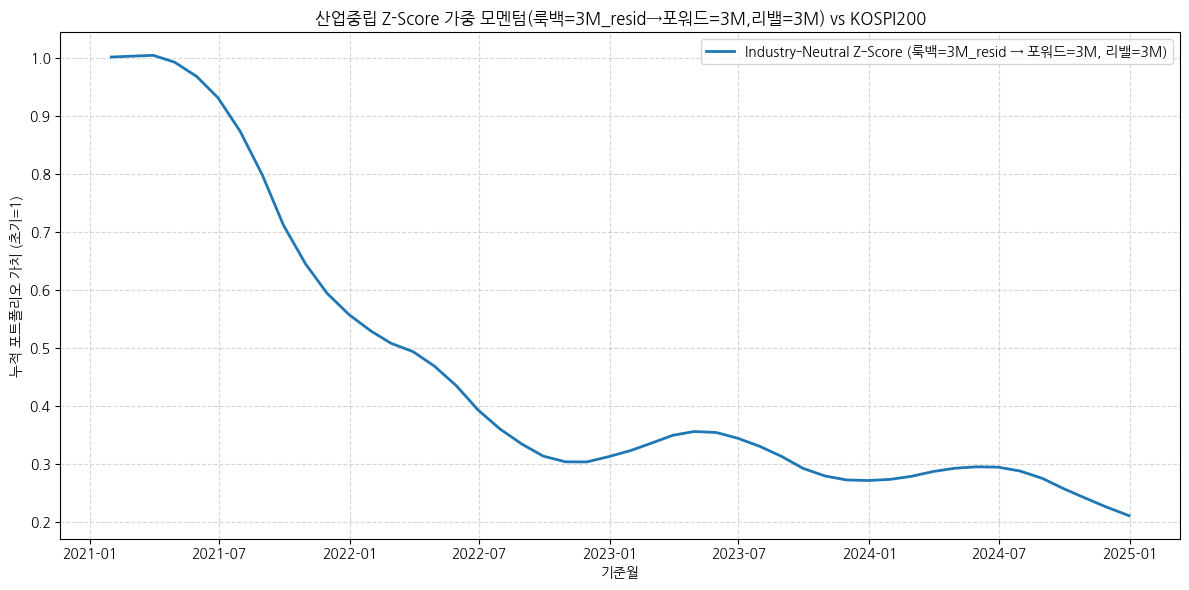

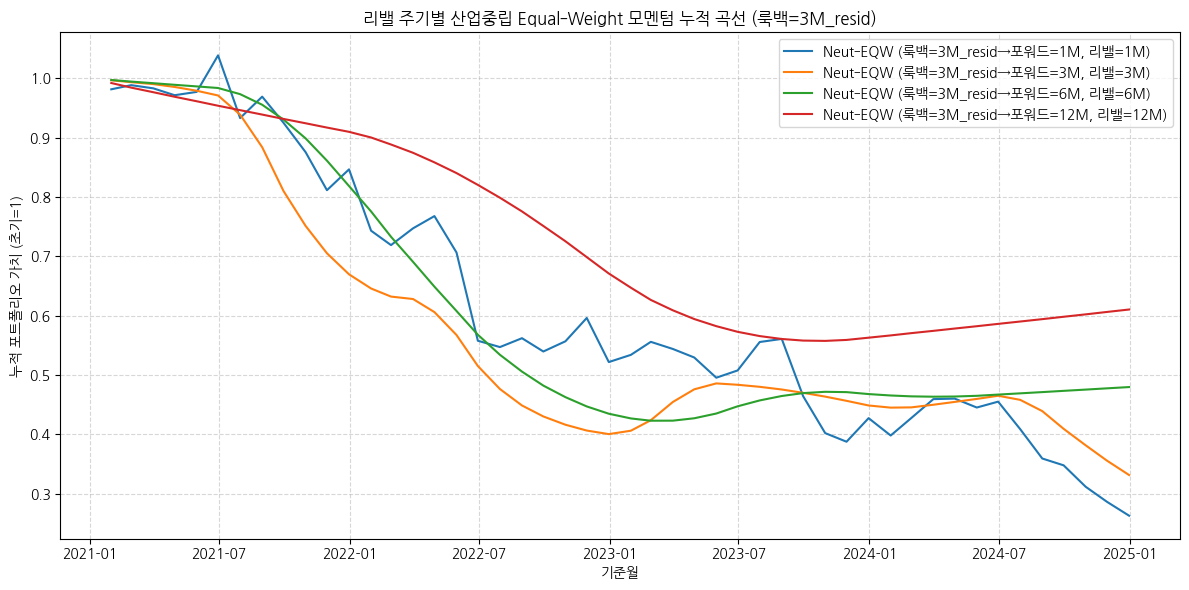

In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

# ───────────────────────────────────────────────────────────────────
# 0) 기본 세팅
# ───────────────────────────────────────────────────────────────────
pd.set_option('display.float_format', '{:.6f}'.format)

# CSV 파일 경로 (각자 환경에 맞게 수정)
csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 및 전처리
# ───────────────────────────────────────────────────────────────────
df = pd.read_csv(csv_path)

# 1A) “기준월”을 datetime(월말)으로 변환
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)

# 1B) 필수 칼럼 확인
required = ['기준월', '종목코드',
            '1개월수익률','3개월수익률','6개월수익률','12개월수익률','산업군']
for col in required:
    if col not in df.columns:
        raise KeyError(f"필수 칼럼 '{col}'이 없습니다.")

# 1C) forward 리턴 컬럼 생성 (shift를 이용한 누적수익)
df = df.sort_values(['종목코드','기준월']).reset_index(drop=True)
df['forward_ret_1m']  = df.groupby('종목코드')['1개월수익률'].shift(-1)
df['forward_ret_3m']  = df.groupby('종목코드')['3개월수익률'].shift(-3)
df['forward_ret_6m']  = df.groupby('종목코드')['6개월수익률'].shift(-6)
df['forward_ret_12m'] = df.groupby('종목코드')['12개월수익률'].shift(-12)

# ───────────────────────────────────────────────────────────────────
# 2) 산업중립 잔차 계산 함수 정의
# ───────────────────────────────────────────────────────────────────
def compute_industry_neutral_residuals(df, lookback_col='3개월수익률', industry_col='산업군'):
    """
    각 기준월별로, y = lookback_col, x = 산업 더미(dummy) + 상수항(const)
    회귀를 돌린 뒤 residual을 {lookback_col}_resid 컬럼으로 붙여서 반환.
    """
    df = df.copy()
    df['month_id'] = df['기준월']  # groupby key
    
    # 빈 DataFrame에 결과 누적
    out = []
    months = df['month_id'].drop_duplicates().sort_values()

    for m in months:
        sub = df[df['month_id'] == m].copy()
        # (A) 산업군을 One-Hot 인코딩 (더미 생성)
        dummies = pd.get_dummies(sub[industry_col], prefix=industry_col)
        # (B) y, X 준비
        y = sub[lookback_col].fillna(0).astype(float)
        X = pd.concat([pd.Series(1, index=y.index, name='const'), dummies.astype(float)], axis=1)

        # (C) OLS 회귀
        model = sm.OLS(y.values, X.values).fit()
        resid = model.resid  # residual array

        # (D) 원본 데이터프레임에 residual 붙이기
        sub[f'{lookback_col}_resid'] = resid
        out.append(sub)

    df_out = pd.concat(out, ignore_index=True)
    return df_out

# 실제로 산업중립 잔차 컬럼을 추가한 데이터프레임 생성
df_ind_resid = compute_industry_neutral_residuals(df, lookback_col='3개월수익률', industry_col='산업군')


# ───────────────────────────────────────────────────────────────────
# 3) 백테스트 함수 정의 (Equal‐Weight 버전)
# ───────────────────────────────────────────────────────────────────
def backtest_topN_equal(df, lookback_col, forward_col, rebalance_months, top_n=20):
    """
    ■ df               : DataFrame, ['기준월','종목코드',lookback_col,forward_col] 필수
    ■ lookback_col     : 예: '3개월수익률' 또는 '3개월수익률_resid'
    ■ forward_col      : 예: 'forward_ret_3m'
    ■ rebalance_months : int, 리밸 주기(1,3,6,12)
    ■ top_n            : int, 상위 N개 종목 편입
    ───────────────────────────────────────────────────────────────────
    매 리밸 시점(rebalance_months 단위)마다 상위 N개를 뽑고, 그들의 forward 수익 평균을 '한 번만' 기록.
    그 뒤 리밸 간격 동안 동일한 월별 수익으로 분할하여 월별 시계열을 만든 뒤 반환.
    """
    # (A) 컬럼 확인
    for c in ['기준월','종목코드',lookback_col,forward_col]:
        if c not in df.columns:
            raise KeyError(f"칼럼 '{c}'이 없습니다.")
    df2 = df.copy()

    # (B) 유니크한 월 리스트
    months = df2['기준월'].drop_duplicates().sort_values().tolist()
    port_ret = pd.Series(index=months, dtype=float)

    # (C) 월별로 리밸 진행
    for idx, cur in enumerate(months):
        if idx % rebalance_months == 0:
            sub = df2[df2['기준월'] == cur].dropna(subset=[lookback_col,forward_col])
            if sub.empty:
                port_ret[cur] = np.nan
            else:
                topN = sub.nlargest(top_n, lookback_col)
                port_ret[cur] = topN[forward_col].mean()
        else:
            port_ret[cur] = np.nan

    # (D) 리밸 구간 전체에 동일 수익을 월별로 분할 (split_return)
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months

    filled = port_ret.fillna(method='ffill')
    all_idx = filled.index.tolist()
    exp_idx, exp_ret = [], []
    for i, mon in enumerate(all_idx):
        r = filled.iloc[i]
        sliced = split_return(r, rebalance_months)
        for m in range(rebalance_months):
            if i + m >= len(all_idx):
                break
            exp_idx.append(all_idx[i + m])
            exp_ret.append(sliced[m])

    monthly_series = pd.Series(data=exp_ret, index=exp_idx).sort_index()
    monthly_series = monthly_series.groupby(level=0).mean()
    return monthly_series.dropna()


# ───────────────────────────────────────────────────────────────────
# 4) 백테스트 함수 정의 (Z‐Score Weight 버전)
# ───────────────────────────────────────────────────────────────────
def backtest_topN_zscore(df, lookback_col, forward_col, rebalance_months, top_n=20):
    """
    ■ df               : DataFrame, ['기준월','종목코드',lookback_col,forward_col] 필수
    ■ lookback_col     : 예: '3개월수익률' 또는 '3개월수익률_resid'
    ■ forward_col      : 예: 'forward_ret_3m'
    ■ rebalance_months : int, 리밸 주기(1,3,6,12)
    ■ top_n            : int, 상위 N개 종목 편입
    ───────────────────────────────────────────────────────────────────
    매 리밸 시점마다 상위 N개 종목 안에서, lookback_col 값의 Cross‐Sectional Z‐Score를 구하여
    그 Z‐Score를 절대값으로 정규화(합=1)한 비중을 부여한 뒤, 가중평균 forward 수익을 계산.
    """
    # (A) 컬럼 확인
    for c in ['기준월','종목코드',lookback_col,forward_col]:
        if c not in df.columns:
            raise KeyError(f"칼럼 '{c}'이 없습니다.")
    df2 = df.copy()

    # (B) 유니크한 월 리스트
    months = df2['기준월'].drop_duplicates().sort_values().tolist()
    port_ret = pd.Series(index=months, dtype=float)

    # (C) 월별 리밸
    for idx, cur in enumerate(months):
        if idx % rebalance_months == 0:
            sub = df2[df2['기준월'] == cur].dropna(subset=[lookback_col,forward_col])
            if sub.empty:
                port_ret[cur] = np.nan
                continue

            # 1) 상위 top_n 종목
            topN = sub.nlargest(top_n, lookback_col).copy()
            lbs = topN[lookback_col].values
            # 2) Cross-sectional Z-Score 계산 (각 월마다 TopN 안에서)
            z = (lbs - lbs.mean()) / (lbs.std(ddof=0) if lbs.std(ddof=0) != 0 else 1)
            # -> 절대값으로 취해야 “더 멀리” 떨어진 쪽이 높은 몸집을 가짐
            w_raw = np.abs(z)
            if w_raw.sum() == 0:
                # 모두 같은 값이어서 Z-Score가 0일 경우, equal-weight 처리
                weights = np.ones_like(w_raw) / len(w_raw)
            else:
                weights = w_raw / w_raw.sum()

            # 3) 가중평균 forward 수익
            fwd = topN[forward_col].values
            port_ret[cur] = np.dot(weights, fwd)
        else:
            port_ret[cur] = np.nan

    # (D) 분할 리턴 로직
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months

    filled = port_ret.fillna(method='ffill')
    all_idx = filled.index.tolist()
    exp_idx, exp_ret = [], []
    for i, mon in enumerate(all_idx):
        r = filled.iloc[i]
        sliced = split_return(r, rebalance_months)
        for m in range(rebalance_months):
            if i + m >= len(all_idx):
                break
            exp_idx.append(all_idx[i + m])
            exp_ret.append(sliced[m])

    monthly_series = pd.Series(data=exp_ret, index=exp_idx).sort_index()
    monthly_series = monthly_series.groupby(level=0).mean()
    return monthly_series.dropna()


# ───────────────────────────────────────────────────────────────────
# 5) 성과 지표 계산 함수
# ───────────────────────────────────────────────────────────────────
def compute_performance_metrics(ret_series, freq=12, rf=0.0):
    """
    ■ ret_series : pandas Series(index=월 datetime, value=월별 수익률)
    ■ freq       : 연환산 주기(12=월별)
    ■ rf         : 무위험 수익률 연환산
    ───────────────────────────────────────────────────────────────────
    누적수익, CAGR, 샤프비율, MDD 계산 후 dict로 반환.
    """
    wealth_index = (1 + ret_series).cumprod()
    cum_return = wealth_index.iloc[-1] - 1

    n_months = len(ret_series)
    n_years = n_months / freq
    cagr = (wealth_index.iloc[-1] ** (1 / n_years) - 1) if n_years > 0 else np.nan

    excess = ret_series - (rf / freq)
    avg_excess = excess.mean() * freq
    std_excess = excess.std() * np.sqrt(freq)
    sharpe = avg_excess / std_excess if std_excess != 0 else np.nan

    running_max = wealth_index.cummax()
    drawdown = (wealth_index / running_max) - 1
    mdd = drawdown.min()

    return {
        'Cumulative': cum_return,
        'CAGR':       cagr,
        'Sharpe':     sharpe,
        'MDD':        mdd
    }


# ───────────────────────────────────────────────────────────────────
# 6) 벤치마크 데이터 가져오기 (KOSPI200 월별 수익률)
# ───────────────────────────────────────────────────────────────────
try:
    kospi = yf.download("^KS200", start="2021-01-01", end="2025-02-01", interval="1mo", progress=False)
    kospi = kospi.dropna(subset=['Adj Close'])
    kospi['monthly_ret'] = kospi['Adj Close'].pct_change()
    bench_ts = kospi['monthly_ret'].dropna()
    bench_ts.index = bench_ts.index.to_period('M').to_timestamp('M')  # 월말로 맞추기
except Exception as e:
    print(">>> 벤치마크(yfinance ^KS200) 다운로드/처리 중 오류 발생:\n", e)
    bench_ts = pd.Series(dtype=float)  # 빈 시리즈로 대체


# ───────────────────────────────────────────────────────────────────
# 7) “원본 모멘텀 vs 산업중립 모멘텀(eqw vs zscore)” 백테스트
# ───────────────────────────────────────────────────────────────────
results = []
rebalance_list = [1, 3, 6, 12]
lookback_base = '3개월수익률'
lookback_neutral = '3개월수익률_resid'
forward_base_list = {1:'forward_ret_1m', 3:'forward_ret_3m', 6:'forward_ret_6m', 12:'forward_ret_12m'}

for rb in rebalance_list:
    fw = forward_base_list[rb]

    # ── 7A) 원본 모멘텀, Equal‐Weight Top50 ────────────────────────────
    ts_orig_eqw = backtest_topN_equal(df, lookback_base, fw, rb, top_n=50)
    perf_orig_eqw = compute_performance_metrics(ts_orig_eqw, freq=12, rf=0.0)

    # ── 7B) 산업중립 모멘텀, Equal‐Weight Top50 ─────────────────────
    ts_neut_eqw = backtest_topN_equal(df_ind_resid, lookback_neutral, fw, rb, top_n=50)
    perf_neut_eqw = compute_performance_metrics(ts_neut_eqw, freq=12, rf=0.0)

    # ── 7C) 산업중립 모멘텀, Z‐Score Weight Top50 ───────────────────
    ts_neut_zsc = backtest_topN_zscore(df_ind_resid, lookback_neutral, fw, rb, top_n=50)
    perf_neut_zsc = compute_performance_metrics(ts_neut_zsc, freq=12, rf=0.0)

    results.append({
        'Rebal (M)':      rb,
        'Orig_EQW_Cum':   perf_orig_eqw['Cumulative'],
        'Orig_EQW_CAGR':  perf_orig_eqw['CAGR'],
        'Orig_EQW_Sharpe':perf_orig_eqw['Sharpe'],
        'Orig_EQW_MDD':   perf_orig_eqw['MDD'],
        'Neut_EQW_Cum':   perf_neut_eqw['Cumulative'],
        'Neut_EQW_CAGR':  perf_neut_eqw['CAGR'],
        'Neut_EQW_Sharpe':perf_neut_eqw['Sharpe'],
        'Neut_EQW_MDD':   perf_neut_eqw['MDD'],
        'Neut_ZSC_Cum':   perf_neut_zsc['Cumulative'],
        'Neut_ZSC_CAGR':  perf_neut_zsc['CAGR'],
        'Neut_ZSC_Sharpe':perf_neut_zsc['Sharpe'],
        'Neut_ZSC_MDD':   perf_neut_zsc['MDD'],
    })

summary_df = pd.DataFrame(results).set_index('Rebal (M)')
print("\n=== 백테스트 성과 요약 (Orig vs Industry‐Neutral) ===\n")
print(summary_df)


# ───────────────────────────────────────────────────────────────────
# 8) 벤치마크와 누적 곡선 비교 시각화
# ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))

# (A) 예시: 리밸=3M, 산업중립 Z‐Score 가중 (룩백=3개월수익률_resid → 포워드=3개월)
rb_example = 3
ts_plot = backtest_topN_zscore(df_ind_resid, lookback_neutral, 'forward_ret_3m', rb_example, top_n=50)
wi_port = (1 + ts_plot).cumprod()

plt.plot(wi_port.index, wi_port.values, label=f"Industry‐Neutral Z‐Score (룩백=3M_resid → 포워드=3M, 리밸=3M)", linewidth=2)

# (B) 벤치마크 누적 곡선
if not bench_ts.empty:
    # 포트폴리오와 동일한 index(월말)만큼 subset
    bench_sub = bench_ts.reindex(wi_port.index).dropna()
    wi_bench = (1 + bench_sub).cumprod()
    plt.plot(wi_bench.index, wi_bench.values, '--', label="KOSPI200 Bench", linewidth=2)

plt.title("산업중립 Z-Score 가중 모멘텀(룩백=3M_resid→포워드=3M,리밸=3M) vs KOSPI200")
plt.xlabel("기준월")
plt.ylabel("누적 포트폴리오 가치 (초기=1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ───────────────────────────────────────────────────────────────────
# 9) 전체 리밸 주기별 누적 곡선 비교
# ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))

for rb in rebalance_list:
    ts_eqw = backtest_topN_equal(df_ind_resid, lookback_neutral, forward_base_list[rb], rb, top_n=50)
    wi_eqw = (1 + ts_eqw).cumprod()
    plt.plot(wi_eqw.index, wi_eqw.values, label=f"Neut‐EQW (룩백=3M_resid→포워드={rb}M, 리밸={rb}M)")

plt.title("리밸 주기별 산업중립 Equal‐Weight 모멘텀 누적 곡선 (룩백=3M_resid)")
plt.xlabel("기준월")
plt.ylabel("누적 포트폴리오 가치 (초기=1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


>>> 벤치마크 다운로드/처리 중 오류 발생:
 ['Adj Close']


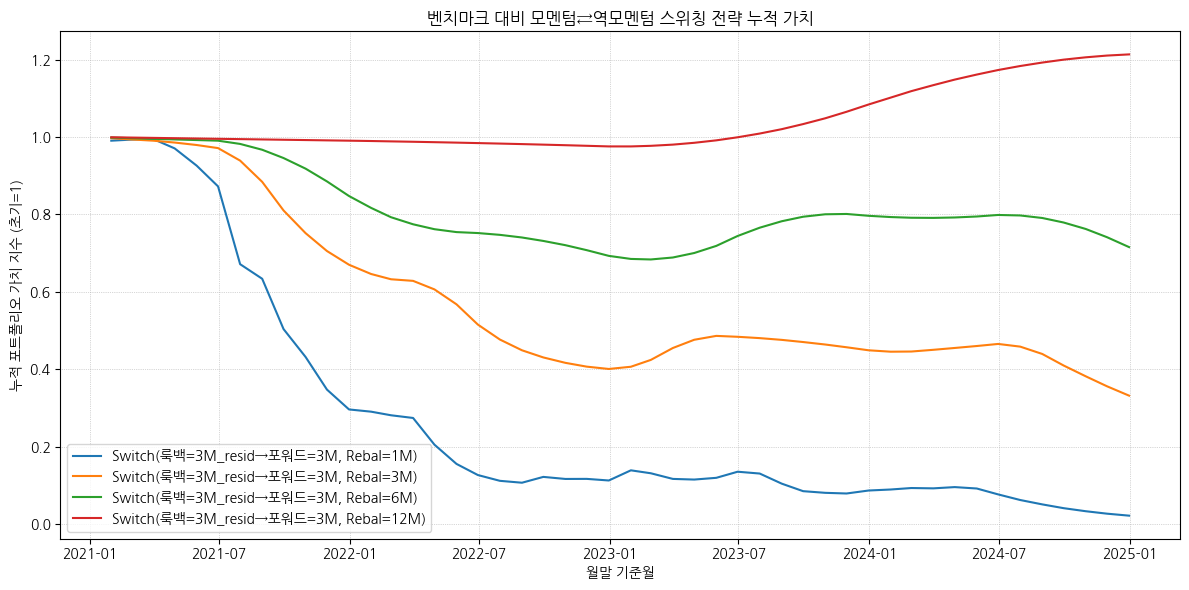


=== 모멘텀⇄역모멘텀 스위칭 전략 성과 요약 ===

          Cumulative      CAGR    Sharpe       MDD
Rebal(M)                                          
1          -0.978718 -0.618052 -2.213478 -0.978600
3          -0.668598 -0.241267 -2.146085 -0.667524
6          -0.284738 -0.080363 -1.381700 -0.315519
12          0.213323  0.049528  2.241330 -0.023719


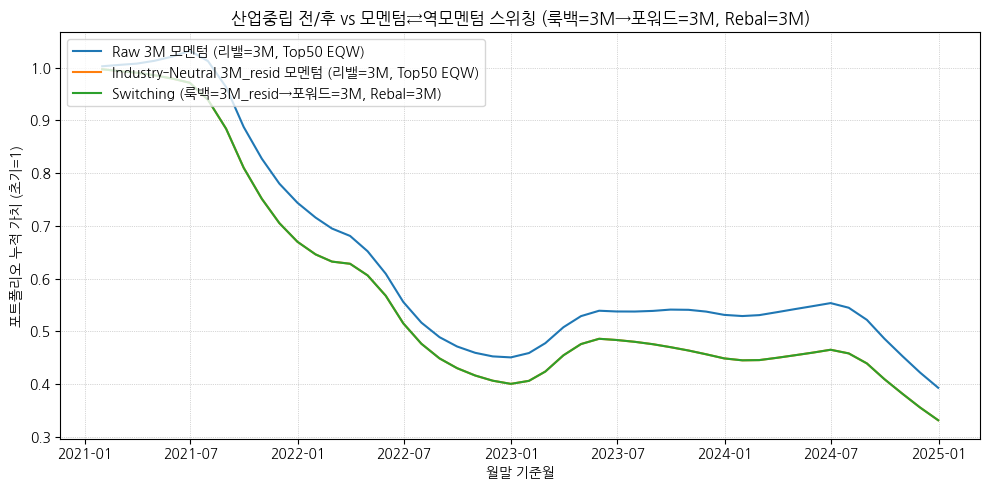

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime

# ─────────────────────────────────────────────────────────────────────────
# 1) 데이터 불러오기 및 전처리
# ─────────────────────────────────────────────────────────────────────────

csv_path = '/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv'
df = pd.read_csv(csv_path)

# 1A) “기준월”을 월말 날짜로 변환 (문자열이 'YYYY-MM' 또는 'YYYY-MM-01' 등인 경우)
df['기준월'] = pd.to_datetime(df['기준월'], errors='raise') + pd.offsets.MonthEnd(0)

# 1B) 필수 컬럼이 있는지 확인
required_cols = ['기준월', '종목코드', '산업군',
                 '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률']
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"필수 칼럼 '{c}' 이(가) 없습니다.")

# 1C) 종목별 forward 누적수익 계산 (shift 이용)
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)
df['forward_ret_1m'] = df.groupby('종목코드')['1개월수익률'].shift(-1)
df['forward_ret_3m'] = df.groupby('종목코드')['3개월수익률'].shift(-3)
df['forward_ret_6m'] = df.groupby('종목코드')['6개월수익률'].shift(-6)
df['forward_ret_12m'] = df.groupby('종목코드')['12개월수익률'].shift(-12)

# ─────────────────────────────────────────────────────────────────────────
# 2) 산업중립 잔차(residual) 계산 함수 (정교화 버전)
# ─────────────────────────────────────────────────────────────────────────

def compute_industry_neutral_residuals(df, lookback_col='3개월수익률', industry_col='산업군'):
    """
    - 매월(month-end) 동일 산업군 더미(dummy) 변수를 만들어 회귀를 돌려서 잔차(resid)만 뽑아냅니다.
    - 결과적으로 입력 df에 '{lookback_col}_resid' 컬럼이 추가된 DataFrame을 반환합니다.
    """
    df = df.copy()
    
    # 1) 산업군이 NaN인 경우가 있으면 ‘기타’로 채우기
    df[industry_col] = df[industry_col].fillna('기타')
    
    # 2) 월별 그룹 단위로 OLS 회귀를 수행
    out_list = []
    for month, sub in df.groupby('기준월'):
        # (a) 회귀용 X: 산업군 더미 + 상수항
        #     → pandas.get_dummies로 카테고리형 → float dtype 보장
        X = pd.get_dummies(sub[industry_col], prefix='IND', drop_first=True).astype(float)
        X = sm.add_constant(X)  # 상수항 추가
        
        # (b) 종속변수 y: lookback_col (NaN 제외)
        y = sub[lookback_col].fillna(0).astype(float)
        
        # (c) OLS 회귀 실행 (y ~ const + 산업군더미)
        model = sm.OLS(y, X).fit()
        
        # (d) 원본 sub 데이터프레임에 잔차만 붙이기
        sub2 = sub.copy()
        sub2[f'{lookback_col}_resid'] = model.resid
        
        out_list.append(sub2)
    
    # 병합해서 반환
    df_out = pd.concat(out_list, ignore_index=True)
    return df_out

# (실제로 잔차 컬럼 생성)
df = compute_industry_neutral_residuals(df, lookback_col='3개월수익률', industry_col='산업군')


# ─────────────────────────────────────────────────────────────────────────
# 3) 백테스트 함수 (모멘텀, 역모멘텀, 스위칭)
# ─────────────────────────────────────────────────────────────────────────

def backtest_with_switching(df, lookback_col, forward_col, rebalance_months, top_n=50):
    """
    ◆ df           : DataFrame, 반드시 ['기준월', '종목코드', lookback_col, forward_col]이 있어야 함
    ◆ lookback_col : 예: '3개월수익률' 또는 '3개월수익률_resid'
    ◆ forward_col  : 예: 'forward_ret_3m'
    ◆ rebalance_months : 리밸 주기 (1, 3, 6, 12)
    ◆ top_n            : 매 리밸 시점에 편입할 상위 N 개수 (예: 50)
    
    【 switching 로직 】  
      - 매 리밸 시점 t에, 바로 전월(t - 1 *month)의 “ 3M 모멘텀 프리미엄 ” 을 계산  
        → ‘3M 모멘텀 프리미엄(t-1)’ :=  
           평균(상위 20% lookback) – 평균(하위 20% lookback),  
           단 lookback_col 기준으로 cross‐sectional quintile을 나눔.  
      - 만약 이 프리미엄이 양(> 0)이면 “모멘텀 롱(Top N)”을,  
        음(< 0)이면 “역모멘텀 롱(Bottom N)”을 편입.  
      - 리밸 간격 동안(=rebalance_months) 동일 비중/가중치로 월별 리턴을 분할 적용.  
      - 매 월 투자할 리밸 시점을 따로 지정하며, 그 외 월은 동일 수익을 분할해서 carry‐forward.
    """
    # 1) 필수 컬럼 확인
    for c in ['기준월', '종목코드', lookback_col, forward_col]:
        if c not in df.columns:
            raise KeyError(f"'{c}' 컬럼이 없습니다.")
    
    df2 = df.copy()
    # (A) 월별로 고유한 기준월을 뽑아 정렬
    all_months = df2['기준월'].drop_duplicates().sort_values().to_list()
    #  결과를 담을 시리즈: index=기준월, 값=편입 종목의 '평균 forward 리턴'
    port_ret = pd.Series(index=all_months, dtype=float)
    
    # (B) 스위칭 로직을 위해 전월 ‘3M 모멘텀 프리미엄’을 미리 계산해둔다
    #     → 각 월 t에 대하여: “lookback_col” 기준으로 cross‐sectional quintile을 구하고,
    #       상위 20% 평균 – 하위 20% 평균을 ‘momentum_premium’으로 칼럼에 붙임.
    premium_list = []
    for month, sub in df2.groupby('기준월'):
        tmp = sub.copy().dropna(subset=[lookback_col, forward_col])
        if tmp.empty:
            premium_list.append((month, np.nan))
            continue
        # 20% / 80% 분위수 구하기
        q_low  = tmp[lookback_col].quantile(0.20)
        q_high = tmp[lookback_col].quantile(0.80)
        low_avg  = tmp.loc[tmp[lookback_col] <= q_low,  lookback_col].mean()
        high_avg = tmp.loc[tmp[lookback_col] >= q_high, lookback_col].mean()
        premium = (high_avg - low_avg)
        premium_list.append((month, premium))
    df_premium = pd.DataFrame(premium_list, columns=['기준월', 'momentum_premium'])
    
    # (C) 실제 리밸∙스위칭
    for idx, month in enumerate(all_months):
        # 매 리밸 시점: idx % rebalance_months == 0
        if idx % rebalance_months == 0:
            # (1) 전월 momentum_premium 확인
            if idx == 0:
                # 첫 달엔 “모멘텀 롱”으로 처리(임의)
                use_contrarian = False
            else:
                prev_month = all_months[idx - 1]
                prev_prem  = df_premium.loc[df_premium['기준월'] == prev_month, 'momentum_premium'].values
                if len(prev_prem) == 0 or pd.isna(prev_prem[0]):
                    # 전월 정보가 없으면 “모멘텀 롱”
                    use_contrarian = False
                else:
                    use_contrarian = (prev_prem[0] < 0)
            
            # (2) 현재월 sub 셋업
            subset = df2[df2['기준월'] == month].dropna(subset=[lookback_col, forward_col])
            if subset.empty:
                port_ret[month] = np.nan
                continue
            
            # (3) 편입할 종목 TopN 또는 BottomN 
            if not use_contrarian:
                # — 일반 모멘텀(Long TopN)
                pick = subset.nlargest(top_n, lookback_col)
            else:
                # — 역모멘텀(Long BottomN)
                pick = subset.nsmallest(top_n, lookback_col)
            
            avg_forward = pick[forward_col].mean()
            port_ret[month] = avg_forward
        
        else:
            port_ret[month] = np.nan
    
    # (D) 리밸 간격 동안 동일 수익을 리턴으로 나누어 퍼뜨리기
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months
    
    port_filled = port_ret.fillna(method='ffill')
    months_list = port_filled.index.to_list()
    expanded_idx = []
    expanded_ret = []
    for i, dt in enumerate(months_list):
        r = port_filled.iloc[i]
        mlist = split_return(r, rebalance_months)
        for m in range(rebalance_months):
            if i + m >= len(months_list):
                break
            expanded_idx.append(months_list[i + m])
            expanded_ret.append(mlist[m])
    monthly_ret = pd.Series(data=expanded_ret, index=expanded_idx).sort_index()
    # 중복 인덱스가 생길 수 있으므로 월별 평균 처리
    monthly_ret = monthly_ret.groupby(monthly_ret.index).mean()
    return monthly_ret.dropna()


# ─────────────────────────────────────────────────────────────────────────
# 4) 벤치마크 불러오기 및 월간 수익률 계산
# ─────────────────────────────────────────────────────────────────────────

# → yfinance로 KOSPI200( ^KS200 ) 월간 Adj Close 받아오기
#    (벤치마크가 없다면 자체 CSV 로딩 등으로 대체하셔야 합니다)
start_date = df['기준월'].min().strftime("%Y-%m-%d")
end_date   = df['기준월'].max().strftime("%Y-%m-%d")

try:
    bench = yf.download('^KS200', start=start_date, end=end_date, interval='1mo', auto_adjust=True)
    bench = bench.dropna(subset=['Adj Close'])
    # 월말 종가 기준 월간 수익률 계산
    bench['monthly_return'] = bench['Adj Close'].pct_change()
    bench = bench.dropna(subset=['monthly_return'])
    # 인덱스를 Timestamp로 맞추기(월말 기준)
    bench.index = pd.to_datetime(bench.index).to_period('M').to_timestamp('M')
    
    # bench_ret: index=월말, value=해당 월 벤치마크 수익률
    bench_ret = bench['monthly_return']
except Exception as e:
    print(">>> 벤치마크 다운로드/처리 중 오류 발생:\n", e)
    bench_ret = pd.Series(dtype=float)  # 빈 시리즈로 초기화


# ─────────────────────────────────────────────────────────────────────────
# 5) 전략별 백테스트 실행
# ─────────────────────────────────────────────────────────────────────────

# (A) “룩백 = 3개월수익률_resid → 포워드 = 3개월” 을 리밸 주기별(1/3/6/12M)로 돌려본다
rebalance_list = [1, 3, 6, 12]

# 결과를 담을 딕셔너리
all_portfolio_ts = {}

for rb in rebalance_list:
    lookback = '3개월수익률_resid'
    forward  = 'forward_ret_3m'
    
    # (i) 스위칭 백테스트 (Top50 Long or Bottom50 Long)
    ts = backtest_with_switching(df, lookback_col=lookback, forward_col=forward,
                                 rebalance_months=rb, top_n=50)
    
    all_portfolio_ts[f'Momentum_Switch_Rebal{rb}M'] = ts


# ─────────────────────────────────────────────────────────────────────────
# 6) 누적 가치(Wealth Index) 계산 및 시각화
# ─────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(12, 6), dpi=100)

# (A) 벤치마크 누적 가치
if not bench_ret.empty:
    bench_wealth = (1 + bench_ret).cumprod()
    plt.plot(bench_wealth.index, bench_wealth.values, 
             color='k', linestyle='--', linewidth=1.5, label='KOSPI200 (벤치마크)')

# (B) 전략별 누적 가치
colors = ['C0', 'C1', 'C2', 'C3']
for i, rb in enumerate(rebalance_list):
    key = f'Momentum_Switch_Rebal{rb}M'
    port_ts = all_portfolio_ts[key]
    wealth = (1 + port_ts).cumprod()
    plt.plot(wealth.index, wealth.values, color=colors[i], 
             label=f'Switch(룩백=3M_resid→포워드=3M, Rebal={rb}M)')

plt.title("벤치마크 대비 모멘텀⇄역모멘텀 스위칭 전략 누적 가치")
plt.xlabel("월말 기준월")
plt.ylabel("누적 포트폴리오 가치 지수 (초기=1)")
plt.legend(loc='lower left')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────────────────────────────────
# 7) 각 전략별 정량 성과 지표(누적, CAGR, Sharpe, MDD) 계산
# ─────────────────────────────────────────────────────────────────────────

def compute_performance_metrics(ret_series, freq=12, rf=0.0):
    """
    ret_series: pandas Series, index=월말(datetime), 값=월간 수익률(소수, 예: 0.02 == 2%)
    freq      : 연환산 주기 (12=월간 데이터)
    rf        : 무위험이자율(연환산)
    """
    if ret_series.empty:
        return {'Cumulative': np.nan, 'CAGR': np.nan, 'Sharpe': np.nan, 'MDD': np.nan}
    
    # (1) Wealth Index
    wealth_index = (1 + ret_series).cumprod()
    cum_return = wealth_index.iloc[-1] - 1
    
    # (2) CAGR
    n_months = len(ret_series)
    n_years  = n_months / freq
    cagr = ( (1 + cum_return) ** (1 / n_years) - 1 ) if n_years > 0 else np.nan
    
    # (3) Sharpe Ratio (excess return 기준)
    excess = ret_series - (rf / freq)
    avg_excess = excess.mean() * freq
    std_excess = excess.std() * np.sqrt(freq)
    sharpe = avg_excess / std_excess if std_excess != 0 else np.nan
    
    # (4) MDD (Maximum Drawdown)
    running_max = wealth_index.cummax()
    drawdown = (wealth_index / running_max) - 1
    mdd = drawdown.min()
    
    return {'Cumulative': cum_return, 'CAGR': cagr, 'Sharpe': sharpe, 'MDD': mdd}


# 전략별 성과 요약 DataFrame
perf_rows = []
for rb in rebalance_list:
    key = f'Momentum_Switch_Rebal{rb}M'
    ts  = all_portfolio_ts[key]
    perf = compute_performance_metrics(ts, freq=12, rf=0.0)
    perf_rows.append({
        'Rebal(M)':      rb,
        'Cumulative':    perf['Cumulative'],
        'CAGR':          perf['CAGR'],
        'Sharpe':        perf['Sharpe'],
        'MDD':           perf['MDD']
    })

perf_df = pd.DataFrame(perf_rows).set_index('Rebal(M)')
print("\n=== 모멘텀⇄역모멘텀 스위칭 전략 성과 요약 ===\n")
print(perf_df)


# ─────────────────────────────────────────────────────────────────────────
# 8) 산업중립 전·후, 스위칭 로직별 간단 비교용 누적 곡선
# ─────────────────────────────────────────────────────────────────────────

# (A) 산업중립 적용 전: raw 3M 모멘텀 Long만 (Rebal=3M, Top50 Equal‐Weight)
def backtest_simple_momentum(df, lookback_col, forward_col, rebalance_months, top_n=50):
    """단순 모멘텀(룩백→포워드) 백테스트 (산업중립 X, 스위칭 X)"""
    # 기본 backtest_topN과 동일 로직: 매 리밸 시점에 lookback_col 상위 TopN 편입
    df2 = df.copy()
    months = df2['기준월'].drop_duplicates().sort_values().to_list()
    portf_ret = pd.Series(index=months, dtype=float)
    for idx, m in enumerate(months):
        if idx % rebalance_months == 0:
            sub = df2[df2['기준월'] == m].dropna(subset=[lookback_col, forward_col])
            if sub.empty:
                portf_ret[m] = np.nan
            else:
                top50 = sub.nlargest(top_n, lookback_col)
                portf_ret[m] = top50[forward_col].mean()
        else:
            portf_ret[m] = np.nan
    # split_return 및 월별 fill‐forward 과정 (위와 동일)
    def split_return(x, months):
        if pd.isna(x):
            return [np.nan] * months
        return [((1 + x) ** (1 / months) - 1)] * months
    port_ff = portf_ret.fillna(method='ffill')
    expanded_idx = []
    expanded_r = []
    for i, m in enumerate(months):
        r = port_ff.iloc[i]
        mr = split_return(r, rebalance_months)
        for j in range(rebalance_months):
            if i + j >= len(months):
                break
            expanded_idx.append(months[i + j])
            expanded_r.append(mr[j])
    s = pd.Series(data=expanded_r, index=expanded_idx).sort_index().groupby(level=0).mean().dropna()
    return s

# (B) 산업중립 적용 후: '3개월수익률_resid' → 3M 포워드, Rebal=3M, Top50 Equal‐Weight
ts_ind_eqw = backtest_simple_momentum(df, '3개월수익률_resid', 'forward_ret_3m', rebalance_months=3, top_n=50)

# (C) 스위칭 로직 (위에서 already 계산된) Rebal=3M
ts_switch_3m = all_portfolio_ts['Momentum_Switch_Rebal3M']

plt.figure(figsize=(10, 5), dpi=100)
# 1) Raw 모멘텀 (산업중립 X)
raw3m = backtest_simple_momentum(df, '3개월수익률', 'forward_ret_3m', rebalance_months=3, top_n=50)
plt.plot((1 + raw3m).cumprod().index, (1 + raw3m).cumprod().values,
         label='Raw 3M 모멘텀 (리밸=3M, Top50 EQW)', color='C0')
# 2) 산업중립 모멘텀
plt.plot(ts_ind_eqw.index, (1 + ts_ind_eqw).cumprod().values,
         label='Industry‐Neutral 3M_resid 모멘텀 (리밸=3M, Top50 EQW)', color='C1')
# 3) 스위칭 로직(모멘텀⇄역모멘텀)
plt.plot(ts_switch_3m.index, (1 + ts_switch_3m).cumprod().values,
         label='Switching (룩백=3M_resid→포워드=3M, Rebal=3M)', color='C2')

plt.title("산업중립 전/후 vs 모멘텀⇄역모멘텀 스위칭 (룩백=3M→포워드=3M, Rebal=3M)")
plt.xlabel("월말 기준월")
plt.ylabel("포트폴리오 누적 가치 (초기=1)")
plt.legend(loc='upper left')
plt.grid(linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()